# complete linkage

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap
class VRPEnvironment:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities,
                 depot_positions, distance_matrix, duration_matrix, speed=50, max_time=10):
        self.num_nodi = len(facility_positions) + len(client_positions) + len(
            depot_positions)  # Consideriamo anche le facility come nodi
        self.nodes_positions = facility_positions + client_positions + depot_positions  # Aggiungiamo le posizioni delle facility

        self.demands = np.array([0] * len(facility_positions) + demands + [0] * len(
            depot_positions))  # Aggiungiamo domanda zero per le facility
        self.facility_positions = facility_positions
        self.client_positions = client_positions
        self.depot_positions = depot_positions
        self.vehicle_capacities = np.array(vehicle_capacities)
        self.facility_capacities = np.array(facility_capacities)
        self.speed = speed  # Velocità in km/h
        self.max_time = max_time  # Tempo massimo in ore
        # Pre-calcola le distanze tra i nodi
        self.distance_matrix = distance_matrix.to_numpy()
        self.duration_matrix = duration_matrix.to_numpy()

    def calcola_distanza(self, node1, node2):
        return self.distance_matrix[node1][node2]

    def calcola_tempo(self, node1, node2):
        return self.duration_matrix[node1][node2] / 60


class QLearningVRP:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities,
                 depot_positions, num_vehicles, distance_matrix, duration_matrix, learning_rate=0.4,
                 discount_factor=0.9,
                 initial_epsilon=1.0, learning_rate_decay=0.99, min_learning_rate=0.01, random_seed=0):
        np.random.seed(random_seed)
        random.seed(random_seed)
        self.env = VRPEnvironment(client_positions, demands, vehicle_capacities, facility_positions,
                                  facility_capacities, depot_positions, distance_matrix, duration_matrix)
        self.num_nodi = len(facility_positions) + len(client_positions) + len(depot_positions)
        self.num_vehicles = num_vehicles
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.exploration_rate = initial_epsilon
        self.initial_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.min_learning_rate = min_learning_rate
        self.q_table = {}
        self.visitati = set()
        self.performance_history = []
        self.facility_visitata_dal_veicolo = [False] * num_vehicles

    def get_state_id(self, cammini):
        state_id = tuple(tuple(cammino) for cammino in cammini)

        if state_id not in self.visitati:
            self.visitati.add(state_id)
            return state_id
        else:
            return state_id

    def aggiorna_q_table(self, state_id, action, reward, next_state_id):
        if state_id not in self.q_table:  # se lo state_id è presente nella Q-table. Se non è presente, lo inizializza come un dizionario vuoto
            self.q_table[state_id] = {}
        if action not in self.q_table[
            state_id]:  # Verifica se l'action è presente nella Q-table per lo state_id. Se non è presente, inizializza il valore di Q per quell'azione a 0
            self.q_table[state_id][action] = 0

        if next_state_id in self.q_table:  #Se next_state_id è presente nella Q-table, calcola td_target come la somma di reward e fattore di sconto moltiplicato per il valore Q dell'azione migliore (best_next_action) nello next_state_id.
            best_next_action = max(self.q_table[next_state_id], key=lambda a: self.q_table[next_state_id][a])
            td_target = reward + self.discount_factor * self.q_table[next_state_id][best_next_action]
        else:
            td_target = reward  #Se next_state_id non è presente nella Q-table, imposta td_target uguale alla reward (poiché non c'è informazione sullo stato successivo)

        td_error = td_target - self.q_table[state_id][
            action]  #Calcola l'errore TD come la differenza tra td_target e il valore Q attuale per lo state_id
        self.q_table[state_id][
            action] += self.learning_rate * td_error  #Aggiorna il valore Q per lo state_id e action utilizzando il learning rate

    def calcola_ricompensa(self, cammini, carico_facilities, log=False):
        # Inizializzazione delle variabili
        tempo_totali = [0] * self.num_vehicles
        carichi = [0] * self.num_vehicles
        distanze_totali = []

        # Calcolo del tempo totale e del carico totale per ciascun veicolo
        for idx, cammino in enumerate(cammini):
            
            for i in range(len(cammino) - 1):
                distanza = self.env.calcola_distanza(cammino[i], cammino[i + 1])
                tempo_totali[idx] += self.env.calcola_tempo(cammino[i], cammino[i + 1])
                carichi[idx] += self.env.demands[cammino[i + 1]]
                distanze_totali.append(distanza)

        #Calcolo della ricompensa basata sul tempo per ogni singolo veicolo
        ricompensa_tempo = 0
        for tempo in tempo_totali:
            ricompensa_veicolo_tempo = -tempo
            if tempo > self.env.max_time:
                ricompensa_veicolo_tempo -= 10 * (tempo - self.env.max_time)
            ricompensa_tempo += ricompensa_veicolo_tempo

        # Calcolo della ricompensa basata sul carico per ogni singolo veicolo
        ricompensa_carico = 0
        for carico in carichi:
            ricompensa_veicolo_carico = 0
            max_vehicle_capacity = np.max(self.env.vehicle_capacities)
            if carico > max_vehicle_capacity:
                ricompensa_veicolo_carico -= (carico - max_vehicle_capacity)
            ricompensa_carico += ricompensa_veicolo_carico

        # Calcolo unfairness
        max_diff = 0
        for i in range(len(distanze_totali)):
            for j in range(i + 1, len(distanze_totali)):
                diff = abs(distanze_totali[i] - distanze_totali[j])
                if diff > max_diff:
                    max_diff = diff

        unfairness = - 100*max_diff

        # Calcolo della ricompensa basata sui carichi delle strutture per ogni singola facility
        ricompensa_facilities = 0
        for i in range(len(carico_facilities)):
            ricompensa_facility = 0
            if carico_facilities[i] > self.env.facility_capacities[i]:
                ricompensa_facility -= 100*(carico_facilities[i] - self.env.facility_capacities[i])
            ricompensa_facilities += ricompensa_facility

        total_reward = (1000 * ricompensa_tempo + ricompensa_carico + unfairness +
                        ricompensa_facilities )

        # Stampa dei dettagli della ricompensa se log è True
        if log:
            print(f"Reward Componenti:\n"
                  f"Tempo: {ricompensa_tempo}\n"
                  f"Carico: {ricompensa_carico}\n"
                  f"Facilities: {ricompensa_facilities}\n"
                  f"Unfairness: {unfairness}\n"
                  f"Total Reward: {total_reward}\n")

        return total_reward

    
    def aggiorna_epsilon(self):
        self.exploration_rate = max(self.exploration_rate * 0.99,
                                        0.01)  
        
    def clustering_agglomerativo(self, n_clusters):
        """
        Esegui il clustering agglomerativo sui nodi e memorizza i cluster per ogni nodo.
        """
        # Costruisci la matrice delle distanze da utilizzare nel clustering
        dist_matrix = self.env.distance_matrix
        dists = squareform(dist_matrix, checks= False)
        
        # Esegui il clustering agglomerativo
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
        cluster_labels = clustering.fit_predict(dist_matrix)
  
        # 1. Dendrogramma del Clustering Agglomerativo
        Z = linkage(dists, method='complete')
        plt.figure(figsize=(13, 10))
        plt.title('Dendrogramma del Clustering Agglomerativo (Complete Linkage)', fontsize= 16)
        dendrogram(Z,color_threshold=175,leaf_font_size=12)
        plt.xlabel('Indice del Nodo',fontsize= 14)
        plt.ylabel('Distanza',fontsize= 14)
        plt.show()

    
        # Suddividi le etichette dei cluster tra nodi, facility e depositi
        node_cluster_labels = cluster_labels[len(self.env.facility_positions):len(self.env.client_positions)+len(self.env.facility_positions)]
        facility_cluster_labels = cluster_labels[:len(self.env.facility_positions)]
        depot_cluster_labels = cluster_labels[len(nodes_posizioni) + len(facility_posizioni):]

        # 2. Scatter Plot dei Cluster con Nodi, Facility e Depositi
        plt.figure(figsize=(12, 8))

        # Posizioni per Scatter Plot
        x_nodes = [pos[1] for pos in self.env.client_positions]  # Longitudine dei nodi
        y_nodes = [pos[0] for pos in self.env.client_positions]  # Latitudine dei nodi
        x_facility = [pos[1] for pos in self.env.facility_positions]  # Longitudine delle facility
        y_facility = [pos[0] for pos in self.env.facility_positions]  # Latitudine delle facility
        x_depot = [pos[1] for pos in self.env.depot_positions]  # Longitudine dei depositi
        y_depot = [pos[0] for pos in self.env.depot_positions]  # Latitudine dei depositi
        custom_cmap = ListedColormap(['#8B0000','#FF8C00','#008000'])
        # Plot Nodi
        plt.scatter(x_nodes, y_nodes, c=node_cluster_labels, cmap=custom_cmap, marker='o', label='Nodi')
        # Plot Facility con lo stesso colore dei cluster dei nodi
        plt.scatter(x_facility, y_facility, c=facility_cluster_labels, cmap=custom_cmap, marker='s', label='Facility')
        # Plot Depositi con lo stesso colore dei cluster dei nodi
        plt.scatter(x_depot, y_depot, c=depot_cluster_labels, cmap= custom_cmap, marker='^', label='Depositi')

        plt.title('Clustering Agglomerativo di Nodi, Facility e Depositi (Complete Linkage)',fontsize=16)
        plt.xlabel('Longitudine',fontsize=14)
        plt.ylabel('Latitudine',fontsize=14)
        plt.colorbar(label='Cluster')
        plt.legend(labelcolor='black')
        plt.grid(True)
        plt.show()
        return cluster_labels
        
    def nodi_per_deposito(self, deposito_index, n_clusters):
        """
        Calcola i nodi visitabili entro un certo raggio dal deposito specificato usando clustering agglomerativo.
        """
        # Esegui il clustering agglomerativo e ottieni le etichette dei cluster
        cluster_labels=self.clustering_agglomerativo(n_clusters)
        
        # Determina i nodi per ciascun deposito in base ai cluster
        nodi_per_deposito_dict = {}
        for deposito in deposito_index:
            nodi_per_deposito_dict[deposito] = []
        
        # Mappa i nodi ai depositi in base ai cluster
        for nodo_index in range(self.num_nodi - len(self.env.depot_positions)):
            cluster_label = cluster_labels[nodo_index]
            for deposito in deposito_index:
                if cluster_labels[deposito] == cluster_label:
                    nodi_per_deposito_dict[deposito].append(nodo_index)
        
        return nodi_per_deposito_dict

    def addestramento(self, num_episodi):

        rewards_history = []
        rewards_cumulative = []
        ultimo_cammino = None
        rewards_per_episode = []
        tempi_totali_per_episode = []

        depot_positions_indices = list(range(self.num_nodi - len(self.env.depot_positions), self.num_nodi))
        dizionario_nodi = self.nodi_per_deposito(depot_positions_indices, 3)

        for episode in range(num_episodi):
            #print(f"=== Episodio {episode + 1} ===")
            start_nodes = depot_positions_indices  # Lista dei nodi deposito
            cammini = [[] for _ in range(self.num_vehicles)]
            nodi_correnti = [None] * self.num_vehicles
            domanda_rimanente = self.env.demands.copy()
            carico_corrente = [0] * self.num_vehicles
            carico_facilities = [0] * len(self.env.facility_positions)
            total_reward = 0
            facility_visitata_dal_veicolo = [False] * self.num_vehicles
            vehicle_active = [True] * self.num_vehicles
            nodo_visitato_dal_veicolo = [False] * self.num_vehicles
            clienti = set(
                range(self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions),
                      self.num_nodi - len(self.env.depot_positions)))
            clienti_da_visitare = clienti.copy()
            facility_set = set(range(self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions)))
            depot_set= set(range(self.num_nodi - len(self.env.depot_positions),self.num_nodi))
            start_node_scelto = [None] * self.num_vehicles
            deposito_scelto = [False] * self.num_vehicles
            depositi_esauriti = set() 

            # Inizializza i cammini e nodi correnti
            while len(clienti_da_visitare) >= 0:
                
                nonvisitati = [node for node in range(self.num_nodi) if node not in start_nodes]
                valid_action = False
                
                # Determina le azioni per ogni veicolo
                for idx, cammino in enumerate(cammini):

                    if not deposito_scelto[idx]:
                        depositi_validi = [depot for depot in start_nodes if depot not in depositi_esauriti]
                        #print(depositi_validi)
                        if np.random.rand() < self.exploration_rate:
                            nodo_successivo = np.random.choice(depositi_validi)
                        else:
                            q_values = [
                                self.q_table.get(self.get_state_id(cammini), {}).get(action, 0)
                                for action in depositi_validi]
                            nodo_successivo =depositi_validi[np.argmax(q_values)]
                    else:
                        # Dopo aver scelto il deposito, calcola i nodi vicini
                        nodi_vicini = dizionario_nodi[start_node_scelto[idx]]
                        nodi_validi = [nodo for nodo in nodi_vicini if nodo in nonvisitati]
                        if len(clienti_da_visitare) == 0: #se sono stati visitati tutti clienti scegli le facility

                            facilities_non_visitati = [node for node in nodi_validi if node in facility_set]

                            facilities_non_visitati_cs = [node for node in facilities_non_visitati
                                if carico_corrente[idx] <= self.env.facility_capacities[node - (
                                        self.num_nodi - len(self.env.client_positions) - len(
                                    self.env.depot_positions))] - carico_facilities[node - (
                                        self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))]]
                            if facilities_non_visitati_cs:
                                if nodo_visitato_dal_veicolo[idx] and not facility_visitata_dal_veicolo[idx]:
                                    if np.random.rand() < self.exploration_rate:
                                        nodo_successivo = np.random.choice(facilities_non_visitati_cs)
                                    else:
                                        q_values = [
                                            self.q_table.get(self.get_state_id(cammini), {}).get(action, 0)
                                            for action in facilities_non_visitati_cs]
                                        nodo_successivo = facilities_non_visitati_cs[np.argmax(q_values)]

                                else:
                                    continue
                            else:
                                # Se non ci sono facilities visitabili
                                facilities_non_visitati_ns = [node for node in nodi_validi if node in facility_set]
                                if facilities_non_visitati_ns:
                                    if nodo_visitato_dal_veicolo[idx] and not facility_visitata_dal_veicolo[idx]:
                                        if np.random.rand() < self.exploration_rate:
                                            nodo_successivo = np.random.choice(facilities_non_visitati_ns)
                                        else:
                                            q_values = [
                                                self.q_table.get(self.get_state_id(cammini), {}).get(action,0) for
                                                action in facilities_non_visitati_ns]
                                            nodo_successivo = facilities_non_visitati_ns[np.argmax(q_values)]
                                    else:
                                        continue



                        elif len(clienti_da_visitare) > 0 : #se ci sono ancora clienti da visitare
                            clienti_nelraggio=[cliente for cliente in clienti_da_visitare if
                                          cliente in nodi_validi]
                            clienti_validi = [cliente for cliente in clienti_da_visitare if
                                          cliente in nodi_validi and
                                          domanda_rimanente[cliente] <= self.env.vehicle_capacities[idx] - carico_corrente[idx]]

                            if not clienti_nelraggio:#se non ci sono più clienti nel raggio/cluster non scegliere più quel deposito
                                depositi_esauriti.add(start_node_scelto[idx])
                                continue

                            if not clienti_validi:
                                continue
                            else:
                                tempi_verso_clienti = [(cliente, self.env.calcola_tempo(nodi_correnti[idx], cliente)) for
                                                       cliente in clienti_validi]
                                tempi_verso_clienti_ordinati = sorted(tempi_verso_clienti, key=lambda x: x[1])
                                clienti_piu_vicini = [tempi_verso_clienti_ordinati[i][0] for i in
                                                      range(min(5, len(tempi_verso_clienti_ordinati)))]
                                if np.random.rand() < self.exploration_rate:
                                    nodo_successivo = np.random.choice(clienti_validi)
                                    
                                else:
                                    q_values = [
                                        self.q_table.get(self.get_state_id(cammini), {}).get(action, 0) for
                                        action in  clienti_piu_vicini]
                                    nodo_successivo =  clienti_piu_vicini[np.argmax(q_values)]


                    if not vehicle_active[idx]:
                        continue

                    if nodo_successivo in depot_set:
                        state_id = self.get_state_id(cammini)
                        cammino.append(nodo_successivo)
                        reward=0
                        next_state_id= self.get_state_id(cammini)
                        self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)
                        start_node_scelto[idx] = nodo_successivo
                        nodi_correnti[idx] = nodo_successivo
                        facility_visitata_dal_veicolo[idx]= False
                        nodo_visitato_dal_veicolo[idx]= False
                        vehicle_active[idx] = True
                        valid_action = True
                        deposito_scelto[idx] = True  # Imposta  per indicare che il deposito è stato scelto
                        break

                    if nodo_successivo in facility_set:  # Facility
                        facility_idx = nodo_successivo - (self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))
                        facility_visitata_dal_veicolo[idx] = True
                        cammino.append(nodo_successivo)
                        carico_facilities[facility_idx] += carico_corrente[idx]
                        nodi_correnti[idx] = nodo_successivo
                        reward = self.calcola_ricompensa(cammini, carico_facilities)
                        # Aggiorna la Q-table
                        state_id = self.get_state_id(cammini[:-1])
                        next_state_id = self.get_state_id(cammini)
                        self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)
                        total_reward += reward
                        carico_corrente[idx] = 0
                        vehicle_active[idx] = False
                        valid_action = True
                        if self.env.facility_capacities[facility_idx] - carico_facilities[facility_idx] <= 0: 
                            nonvisitati.remove(nodo_successivo)
                        break




                    elif nodo_successivo in clienti_da_visitare:
                        cammino.append(nodo_successivo)
                        carico_corrente[idx] += domanda_rimanente[nodo_successivo]
                        domanda_rimanente[nodo_successivo] = 0
                        nodi_correnti[idx] = nodo_successivo
                        reward = self.calcola_ricompensa(cammini,carico_facilities)
                        # Aggiorna la Q-table
                        state_id = self.get_state_id(cammini[:-1])
                        next_state_id = self.get_state_id(cammini)
                        self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)
                        total_reward += reward
                        facility_visitata_dal_veicolo[idx]= False
                        nodo_visitato_dal_veicolo[idx] = True  # indica se il veicolo ha visitato almeno un nodo
                        vehicle_active[idx] = True
                        valid_action = True
                        nonvisitati.remove(nodo_successivo)
                        clienti_da_visitare.remove(nodo_successivo)
                        break

                if not valid_action:
                    break

            # I veicoli ritornano ai rispettivi depositi
            for idx in range(self.num_vehicles):
                cammini[idx].append(start_node_scelto[idx])
                
            # Calcola la ricompensa finale e aggiungi il valore al reward totale
            ricompensa_finale = self.calcola_ricompensa(cammini, carico_facilities)
            total_reward += ricompensa_finale
            rewards_history.append(total_reward)
            rewards_cumulative.append(np.sum(rewards_history))
            rewards_per_episode.append(total_reward)

            # Calcolo dei tempi totali per ogni veicolo in questo episodio
            tempi_totali = [0] * self.num_vehicles
            for idx, cammino in enumerate(cammini):
                for i in range(len(cammino) - 1):
                    tempi_totali[idx] += self.env.calcola_tempo(cammino[i], cammino[i + 1])

            tempi_totali_per_episode.append(np.sum(tempi_totali))

            # Aggiorna il valore di epsilon usando la strategia epsilon greedy 
            if (episode + 1) % 5 == 0:
                self.performance_history.append(total_reward)
                self.aggiorna_epsilon()

                self.learning_rate = max(self.min_learning_rate,
                                     self.initial_learning_rate * (self.learning_rate_decay ** episode))


            ultimo_cammino = cammini
            if (episode + 1) % 5 == 0:
                print(
                    f'Episodio: {episode + 1}, Reward: {total_reward}, Epsilon: {self.exploration_rate},Learning Rate: {self.learning_rate}, tempo: {np.sum(tempi_totali)}')

            if (episode + 1) == num_episodi:
                print("\nCapacità delle facilities:")
                for idx, capacity in enumerate(self.env.facility_capacities):
                    current_load = carico_facilities[idx]
                    print(f"Facility {idx}: Capacità={capacity}, Carico attuale={current_load}\n")

                print("\nPercorso dei veicoli:")
                for idx, cammino in enumerate(ultimo_cammino):
                    print(f"Veicolo {idx}: {cammino}")
                    # Ottieni il tempo totale già calcolato
                    tempo_totale_veicolo = tempi_totali[idx]
                    print(f"    Tempo totale veicolo {idx}: {tempo_totale_veicolo}")

        return rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode, tempi_totali_per_episode

    def plot_cammino(self, node_names, cammini, start_label="depot", end_label="end", save_cammino=None):
        plt.figure(figsize=(20, 10))
        nodes_positions = self.env.nodes_positions

        # Filtra i cammini validi (cammini con più di un nodo)
        cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
        num_veicoli_utilizzati = len(cammini_validi)

        # Colormap per veicoli utilizzati
        colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)

        # Plot solo i veicoli utilizzati
        for idx, cammino in enumerate(cammini_validi):
            veicolo_id = cammini.index(cammino)  # Ottieni l'ID corretto del veicolo
            print(veicolo_id)

            coords = [nodes_positions[node] for node in cammino]
            xs, ys = zip(*coords)
            plt.plot(ys, xs, marker='o', color=colors(idx), label=f'Veicolo {veicolo_id}')

            for i, node in enumerate(cammino):
                if node in range(len(nodes_positions) - len(self.env.depot_positions), len(nodes_positions)):  # depot
                    label_color = 'red'
                    label = node_names[node]
                elif node in range(
                        len(nodes_positions) - len(self.env.client_positions) - len(self.env.depot_positions)):
                    label_color = 'green'
                    label = node_names[node]
                else:
                    label_color = 'black'
                    label = node_names[node] if node < len(node_names) else f'Node {node + 1}'
                plt.annotate(label, (ys[i], xs[i]), textcoords="offset points", xytext=(0, 10), ha='center',
                             color=label_color)

        # Aggiungi marker per facility e depot
        plt.scatter([], [], c='red', marker='o', label='Depot')
        plt.scatter([], [], c='green', marker='o', label='Facility')

        plt.xlabel('Longitudine',fontsize= 14)
        plt.ylabel('Latitudine',fontsize= 14)
        plt.title('Percorsi dei Veicoli (Complete Linkage)',fontsize= 16)
        plt.grid(True)
        plt.legend()  # Aggiunge la legenda
        if save_cammino:
            plt.savefig(save_cammino)
        plt.show()

    def plot_rewards_per_episode(self, rewards_per_episode, window_size=50):
        # Calcola la media mobile
        moving_avg_rewards = np.convolve(rewards_per_episode, np.ones(window_size) / window_size, mode='valid')

        plt.figure(figsize=(16, 10))
        plt.plot(rewards_per_episode, marker='o', linestyle='-', label='Ricompense per Episodio')
        plt.plot(range(window_size - 1, len(rewards_per_episode)), moving_avg_rewards, color='r', linestyle='-',
                 linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Ricompense Totali per Episodio con Media Mobile (Complete Linkage)',fontsize= 16)
        plt.xlabel('Episodio',fontsize= 14)
        plt.ylabel('Ricompensa Totale',fontsize= 14)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_tempi_totali_per_episode(self, tempi_totali_per_episode, window_size=50):
        moving_avg_tempi = np.convolve(tempi_totali_per_episode, np.ones(window_size) / window_size, mode='valid')

        plt.figure(figsize=(16, 10))
        plt.plot(tempi_totali_per_episode, marker='o', linestyle='-', label='Tempi Totali per Episodio')
        plt.plot(range(window_size - 1, len(tempi_totali_per_episode)), moving_avg_tempi, color='r', linestyle='-',
                 linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Tempi Totali per Episodio con Media Mobile (Complete Linkage)',fontsize= 16)
        plt.xlabel('Episodio',fontsize= 14)
        plt.ylabel('Tempo Totale',fontsize= 14)
        plt.legend()
        plt.grid(True)
        plt.show()



    def stampa_dimensioni_q_table(self):
        num_stati = len(self.q_table)          
        azioni_uniche = set()
    
        # Itera attraverso tutti gli stati nella Q-table
        for stato in self.q_table:
            # Aggiungi tutte le azioni per questo stato al set di azioni uniche
            azioni_uniche.update(self.q_table[stato].keys())
        
        # Calcola il numero di azioni uniche
        num_azioni_differenti = len(azioni_uniche)
    


        print(f"Dimensione finale della Q-table: {num_stati} righe (stati) x {num_azioni_differenti} colonne (azioni)")

    def estrai_variabili_json(self, cammini):
        h = dict()
        z = dict()

        # Inizializza tutte le variabili h a 0
        for veicolo in range(self.num_vehicles):
            for nodo in range(self.num_nodi):
                h[f"({veicolo}, {nodo})"] = 0.0

        # Inizializza tutte le variabili z a 0
        for veicolo in range(self.num_vehicles):
            for nodo_corrente in range(self.num_nodi):
                for nodo_successivo in range(self.num_nodi):
                    z[f"({veicolo}, {nodo_corrente}, {nodo_successivo})"] = 0.0

        cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
        for veicolo, cammino in enumerate(cammini_validi):
            veicolo_id = cammini.index(cammino)
            # Aggiungi le variabili h
            for nodo in cammino:
                h[f"({veicolo_id}, {nodo})"] = 1.0

            # Aggiungi le variabili z
            for i in range(len(cammino) - 1):
                nodo_corrente = cammino[i]
                nodo_successivo = cammino[i + 1]
                z[f"({veicolo_id}, {nodo_corrente}, {nodo_successivo})"] = 1.0

        return {"h": h, "z": z}


file_path = 'data/output - Copia.xlsx'
dfnodi = pd.read_excel(file_path, sheet_name="nodi")
matrice_distanze = pd.read_csv('data/distance_matrix-orig.csv', index_col=0)
matrice_durate = pd.read_csv('data/duration_matrix.csv', index_col=0)

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
lat = dfnodi['lat']
long = dfnodi['long']
node_names = dfnodi[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
nodes_posizioni = [[lat[i], long[i]] for i in range(len(dfnodi))]


# Crea un array per le domande dei nodi
demands = dfnodi["demand_daily"].tolist()

#depot
file_path = 'data/output - Copia.xlsx'
dfdepot = pd.read_excel(file_path, sheet_name="depot")
latdepot = dfdepot['lat']
longdepot = dfdepot['long']
depot_names = dfdepot[node_name_column]
# Crea un array bidimensionale di posizioni dei nodi

depot_posizioni = [[latdepot[i], longdepot[i]] for i in range(len(dfdepot))]


# Carica il file Excel delle strutture
file_path = 'data/output - Copia.xlsx'
dffacility = pd.read_excel(file_path, sheet_name="facility")

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
latf = dffacility['lat']
longf = dffacility['long']
facility_names = dffacility[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
facility_posizioni = [[latf[i], longf[i]] for i in range(len(dffacility))]


# Crea un array per le domande dei nodi
facility_capacities = dffacility["facility_capacity"].tolist()

# Converti node_names in una lista e poi estendila
node_names = node_names.tolist()
facility_names = facility_names.tolist()

depot_names = depot_names.tolist()

facility_names.extend(node_names)
facility_names.extend(depot_names)
#
num_veicoli = 60
vehicle_capacities = [40] * num_veicoli





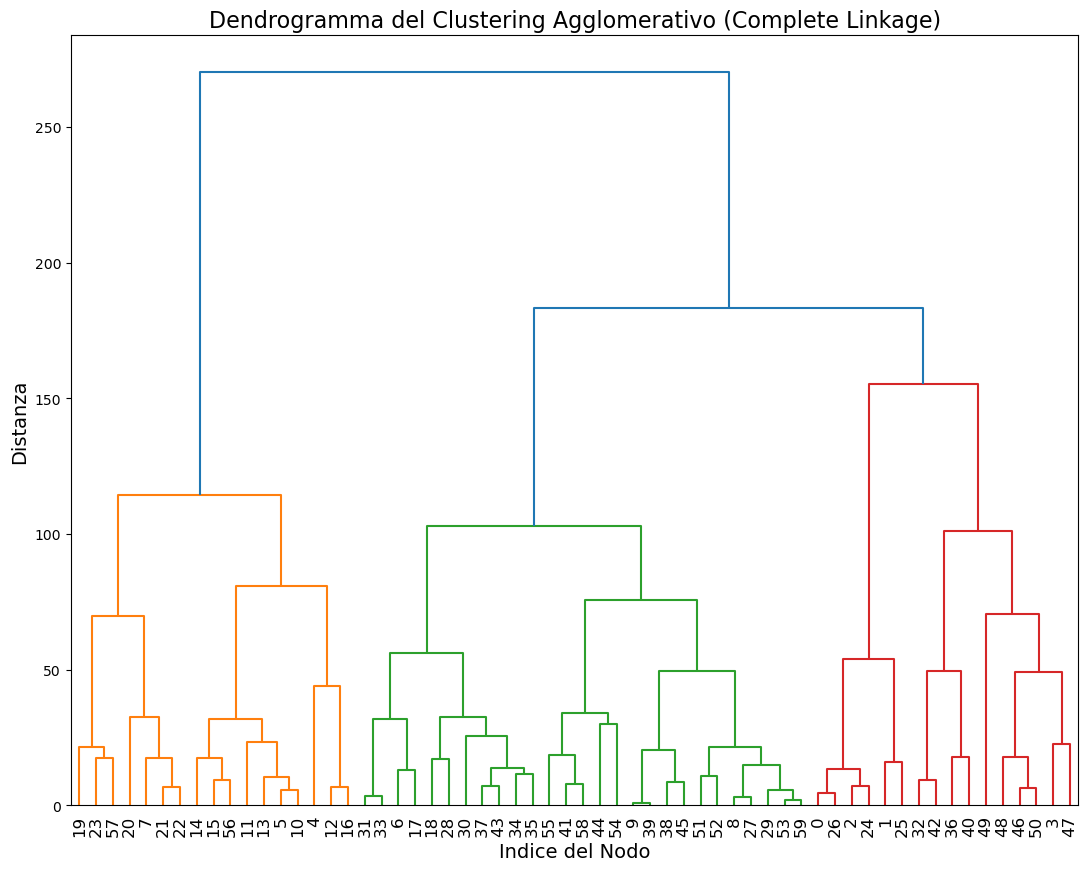

Cophenetic Correlation Coefficient: 0.799


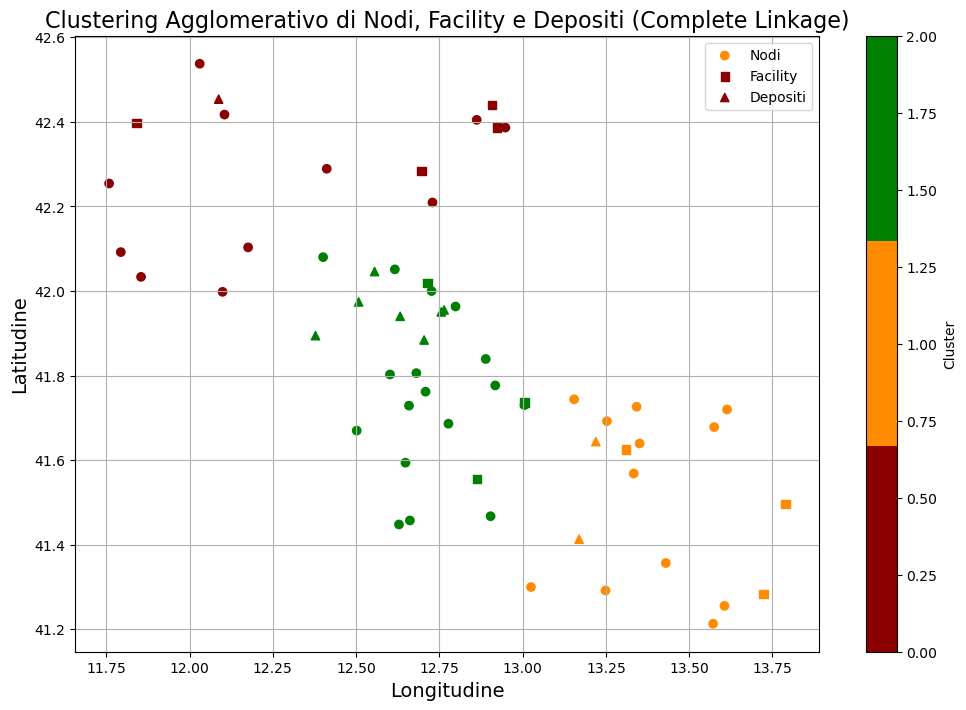

Episodio: 5, Reward: -3012906.1666666665, Epsilon: 0.99,Learning Rate: 0.384238404, tempo: 58.99816666666668
Episodio: 10, Reward: -3551526.333333333, Epsilon: 0.9801,Learning Rate: 0.36540689899345635, tempo: 57.66000000000001
Episodio: 15, Reward: -4355937.499999999, Epsilon: 0.9702989999999999,Learning Rate: 0.3474983251075913, tempo: 52.977666666666664
Episodio: 20, Reward: -4586363.666666667, Epsilon: 0.96059601,Learning Rate: 0.3304674495342347, tempo: 52.804
Episodio: 25, Reward: -3699105.3333333335, Epsilon: 0.9509900498999999,Learning Rate: 0.31427125632288755, tempo: 57.91833333333334
Episodio: 30, Reward: -3777978.3333333326, Epsilon: 0.9414801494009999,Learning Rate: 0.29886883773263845, tempo: 50.80083333333333
Episodio: 35, Reward: -3234478.333333333, Epsilon: 0.9320653479069899,Learning Rate: 0.28422129090891685, tempo: 58.9615
Episodio: 40, Reward: -2533840.1666666665, Epsilon: 0.92274469442792,Learning Rate: 0.27029161962411324, tempo: 58.555499999999995
Episodio: 45, 

In [11]:
# Creazione dell'agente di Q-learning
ql_vrp = QLearningVRP(nodes_posizioni, demands, vehicle_capacities, facility_posizioni, facility_capacities,
                      depot_posizioni, num_veicoli, matrice_distanze, matrice_durate)

# Addestramento dell'agente #3980

rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode, tempi_totali_per_episode = ql_vrp.addestramento(
    num_episodi=4000)  #5000


#impiega per l'addestramento 3 min e 50

C:\Users\eleon\AppData\Local\Temp\ipykernel_5760\1676695088.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)


0
1
2
3
8
9


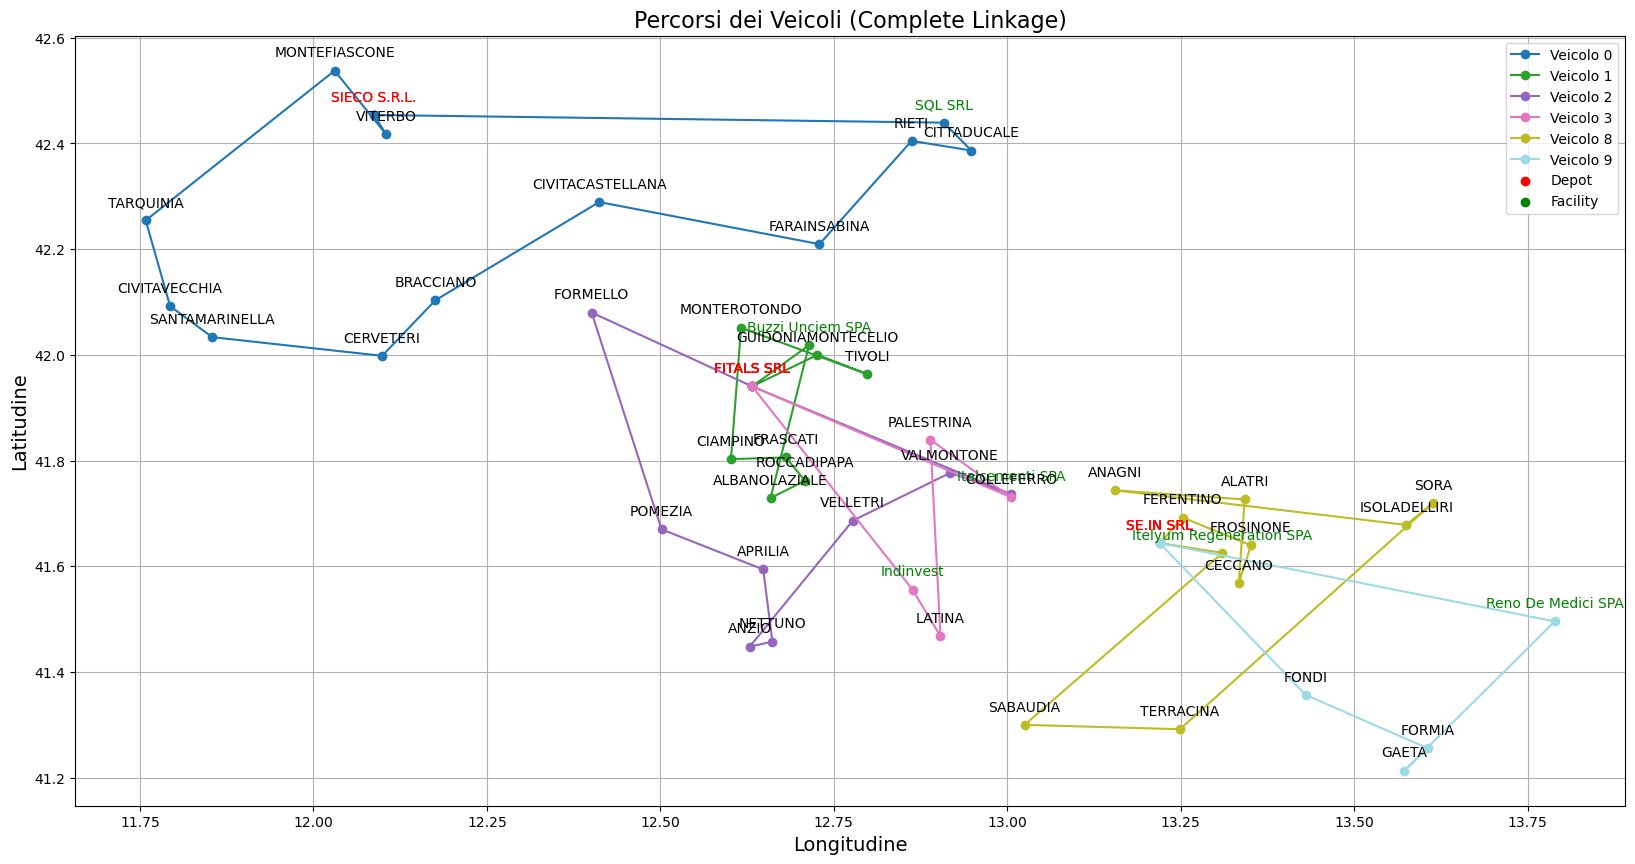

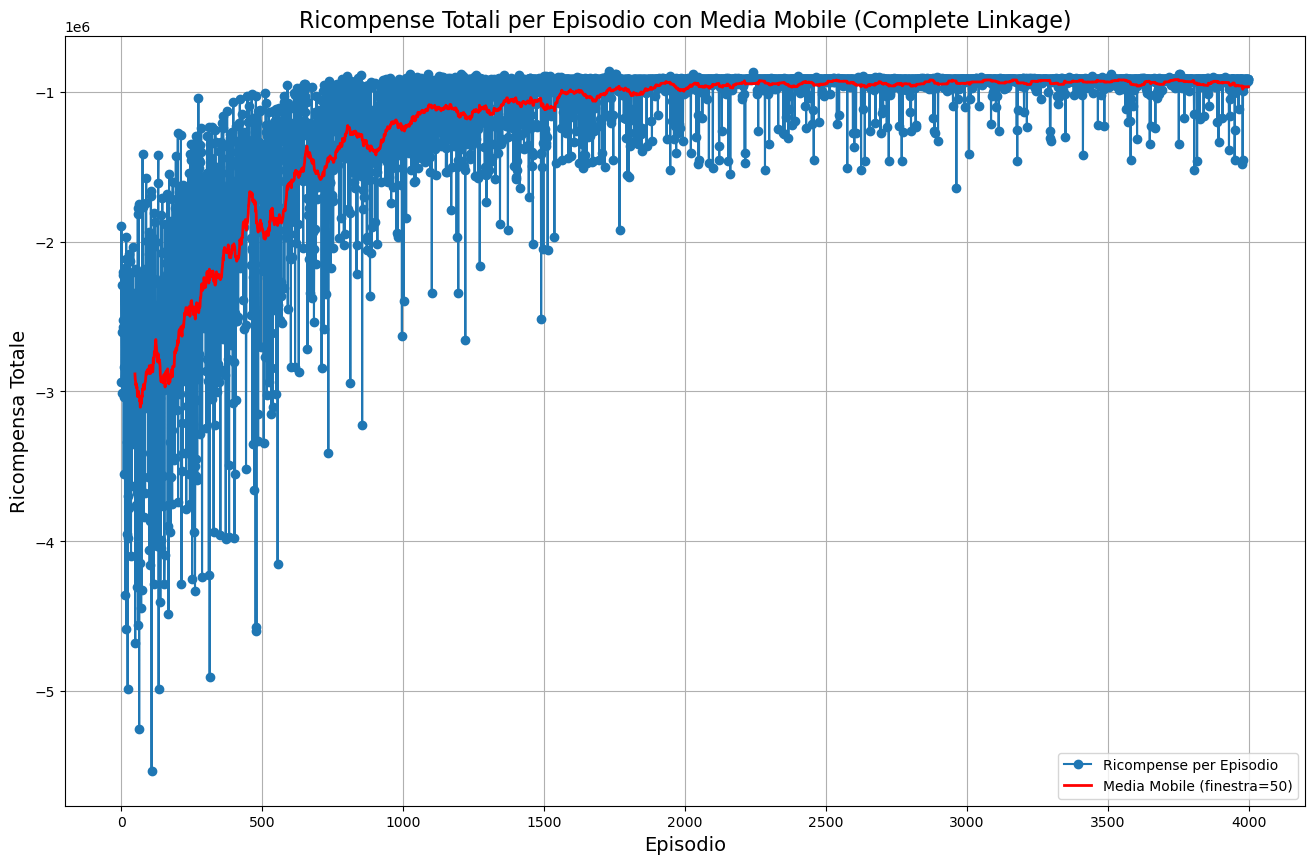

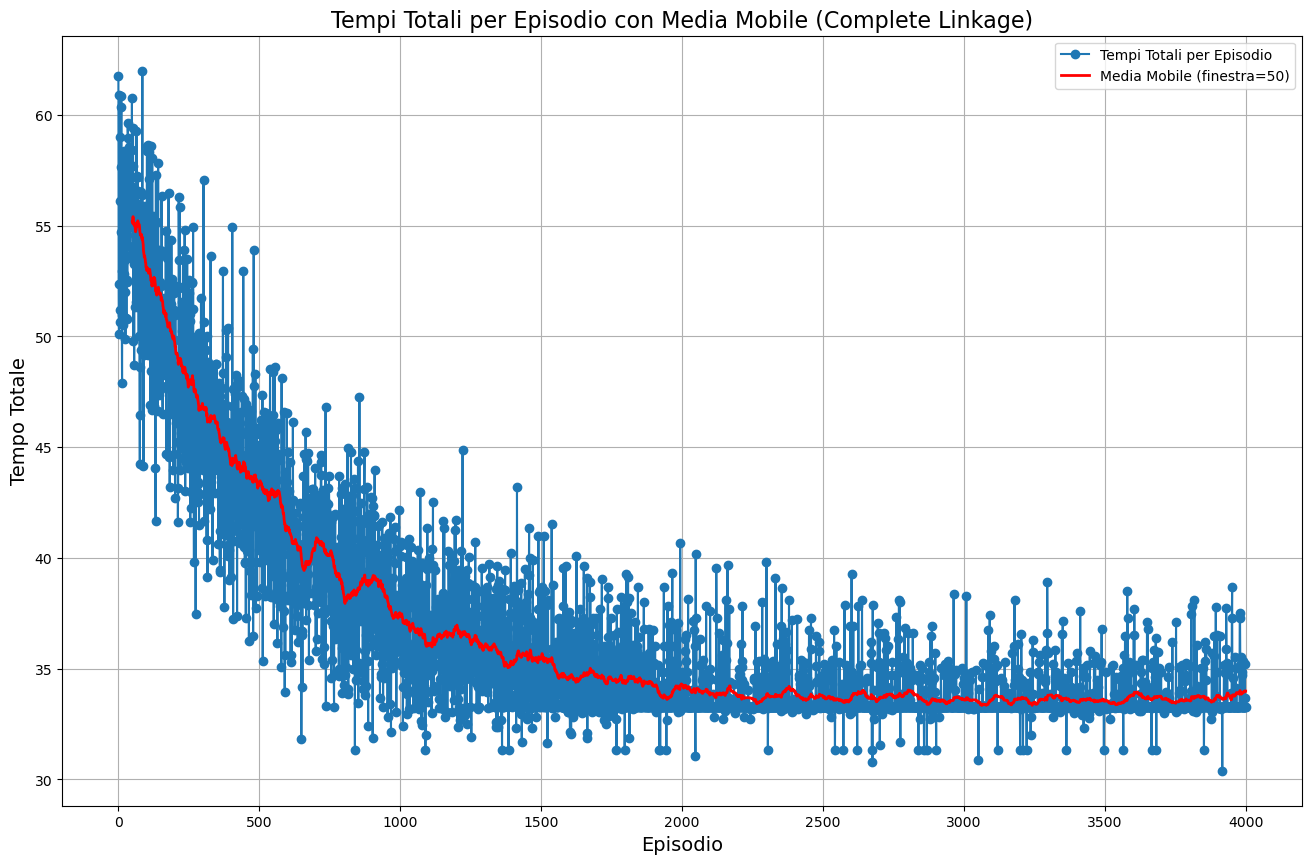

In [12]:
# # Visualizzazione dell'ultimo cammino trovato
ql_vrp.plot_cammino(facility_names, ultimo_cammino)
ql_vrp.plot_rewards_per_episode(rewards_per_episode, window_size=50)
# Plottare i tempi totali per episodio
ql_vrp.plot_tempi_totali_per_episode(tempi_totali_per_episode)


In [8]:
import json
# Estrazione delle variabili in formato JSON
variabili_json = ql_vrp.estrai_variabili_json(ultimo_cammino)

# salva il JSON
json_output = json.dumps(variabili_json, indent=4)

# Salva il JSON su un file
with open("formulazione/percorsi_formulazione-completelinkage2409.json", "w") as file:
    file.write(json_output)

## gurobi

h_dict: {(0, 5): 1.0, (0, 10): 1.0, (0, 13): 1.0, (0, 56): 1.0, (2, 9): 1.0, (2, 18): 1.0, (2, 28): 1.0, (2, 30): 1.0, (2, 31): 1.0, (2, 33): 1.0, (2, 34): 1.0, (2, 43): 1.0, (2, 52): 1.0, (5, 3): 1.0, (5, 32): 1.0, (5, 36): 1.0, (5, 40): 1.0, (5, 42): 1.0, (5, 46): 1.0, (5, 47): 1.0, (5, 48): 1.0, (5, 50): 1.0, (11, 8): 1.0, (11, 27): 1.0, (11, 29): 1.0, (11, 35): 1.0, (11, 37): 1.0, (11, 38): 1.0, (11, 44): 1.0, (11, 45): 1.0, (11, 49): 1.0, (11, 53): 1.0, (21, 5): 1.0, (21, 11): 1.0, (21, 12): 1.0, (21, 14): 1.0, (21, 15): 1.0, (21, 16): 1.0, (21, 39): 1.0, (21, 56): 1.0, (38, 6): 1.0, (38, 17): 1.0, (38, 19): 1.0, (38, 20): 1.0, (38, 21): 1.0, (38, 22): 1.0, (38, 23): 1.0, (38, 57): 1.0, (40, 2): 1.0, (40, 24): 1.0, (40, 25): 1.0, (40, 26): 1.0, (40, 41): 1.0, (40, 58): 1.0}
z_dict: {(0, 5, 56): 1.0, (0, 10, 5): 1.0, (0, 13, 10): 1.0, (0, 56, 13): 1.0, (2, 9, 52): 1.0, (2, 18, 31): 1.0, (2, 28, 18): 1.0, (2, 30, 9): 1.0, (2, 31, 33): 1.0, (2, 33, 30): 1.0, (2, 34, 28): 1.0, (2, 43,

C:\Users\eleon\AppData\Local\Temp\ipykernel_15872\2320673072.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_vehicles)


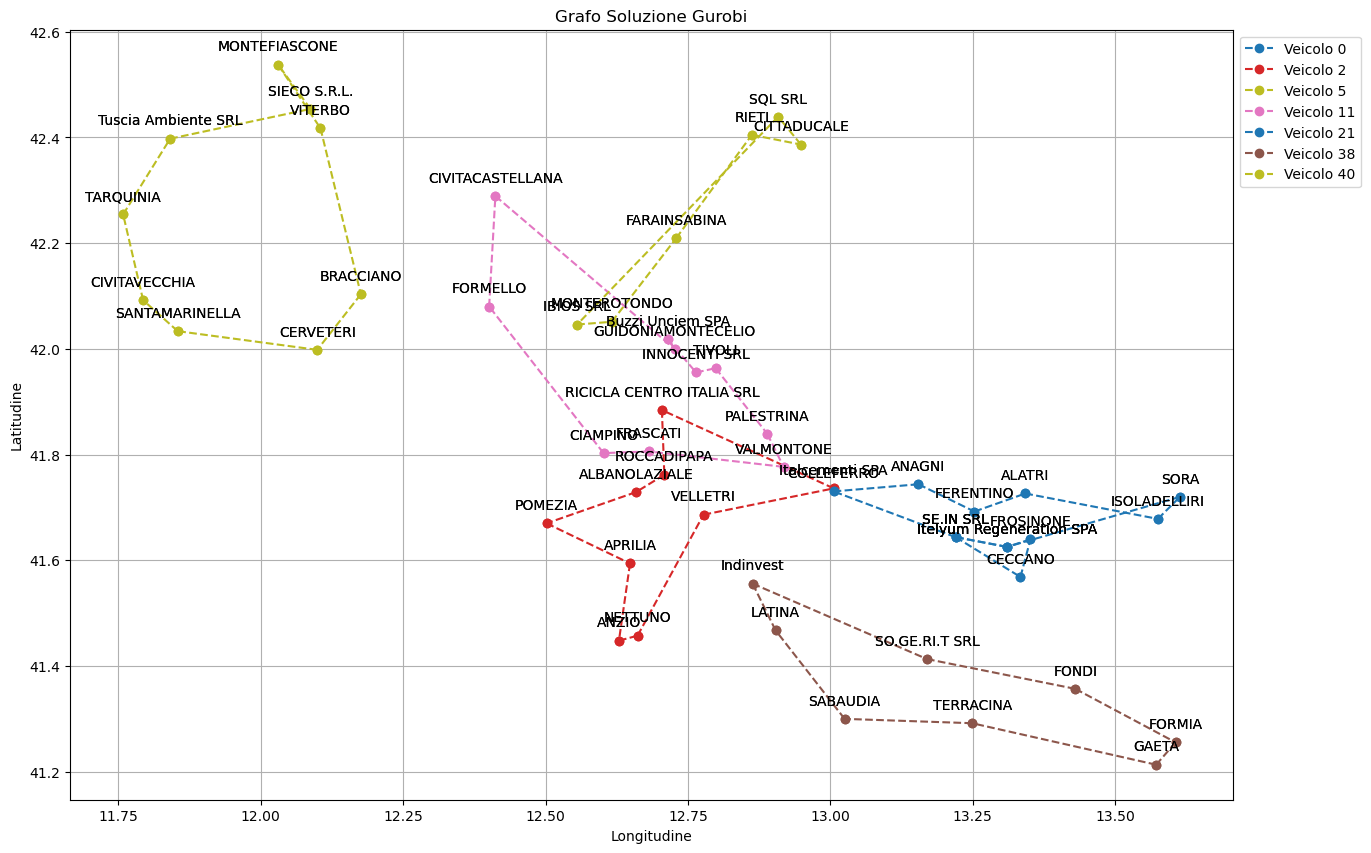

Tempo totale di percorrenza per il veicolo 0: 1.11 ore
Tempo totale di percorrenza per il veicolo 2: 4.43 ore
Tempo totale di percorrenza per il veicolo 5: 4.95 ore
Tempo totale di percorrenza per il veicolo 11: 5.36 ore
Tempo totale di percorrenza per il veicolo 21: 3.64 ore
Tempo totale di percorrenza per il veicolo 38: 4.88 ore
Tempo totale di percorrenza per il veicolo 40: 3.82 ore
Tempo totale di percorrenza di tutti i veicoli: 28.1855
Percorso del veicolo 0:
5,Itelyum Regeneration SPA -> 56,SE.IN SRL
10,FROSINONE -> 5,Itelyum Regeneration SPA
13,CECCANO -> 10,FROSINONE
56,SE.IN SRL -> 13,CECCANO

Percorso del veicolo 2:
9,Italcementi SPA -> 52,RICICLA CENTRO ITALIA SRL
18,APRILIA -> 31,ANZIO
28,POMEZIA -> 18,APRILIA
30,VELLETRI -> 9,Italcementi SPA
31,ANZIO -> 33,NETTUNO
33,NETTUNO -> 30,VELLETRI
34,ALBANOLAZIALE -> 28,POMEZIA
43,ROCCADIPAPA -> 34,ALBANOLAZIALE
52,RICICLA CENTRO ITALIA SRL -> 43,ROCCADIPAPA

Percorso del veicolo 5:
3,Tuscia Ambiente SRL -> 50,SIECO S.R.L.
32,CIVI

In [8]:
import pandas as pd
# Dati iniziali di h e z
h_data = {(0, 5): 1.0, (0, 10): 1.0, (0, 13): 1.0, (0, 56): 1.0, (2, 9): 1.0, (2, 18): 1.0, (2, 28): 1.0, (2, 30): 1.0, (2, 31): 1.0, (2, 33): 1.0, (2, 34): 1.0, (2, 43): 1.0, (2, 52): 1.0, (5, 3): 1.0, (5, 32): 1.0, (5, 36): 1.0, (5, 40): 1.0, (5, 42): 1.0, (5, 46): 1.0, (5, 47): 1.0, (5, 48): 1.0, (5, 50): 1.0, (11, 8): 1.0, (11, 27): 1.0, (11, 29): 1.0, (11, 35): 1.0, (11, 37): 1.0, (11, 38): 1.0, (11, 44): 1.0, (11, 45): 1.0, (11, 49): 1.0, (11, 53): 1.0, (21, 5): 1.0, (21, 11): 1.0, (21, 12): 1.0, (21, 14): 1.0, (21, 15): 1.0, (21, 16): 1.0, (21, 39): 1.0, (21, 56): 1.0, (38, 6): 1.0, (38, 17): 1.0, (38, 19): 1.0, (38, 20): 1.0, (38, 21): 1.0, (38, 22): 1.0, (38, 23): 1.0, (38, 57): 1.0, (40, 2): 1.0, (40, 24): 1.0, (40, 25): 1.0, (40, 26): 1.0, (40, 41): 1.0, (40, 58): 1.0}


z_data = {(0, 5, 56): 1.0, (0, 10, 5): 1.0, (0, 13, 10): 1.0, (0, 56, 13): 1.0, (2, 9, 52): 1.0, (2, 18, 31): 1.0, (2, 28, 18): 1.0, (2, 30, 9): 1.0, (2, 31, 33): 1.0, (2, 33, 30): 1.0, (2, 34, 28): 1.0, (2, 43, 34): 1.0, (2, 52, 43): 1.0, (5, 3, 50): 1.0, (5, 32, 47): 1.0, (5, 36, 42): 1.0, (5, 40, 36): 1.0, (5, 42, 32): 1.0, (5, 46, 40): 1.0, (5, 47, 3): 1.0, (5, 48, 46): 1.0, (5, 50, 48): 1.0, (11, 8, 53): 1.0, (11, 27, 8): 1.0, (11, 29, 38): 1.0, (11, 35, 44): 1.0, (11, 37, 35): 1.0, (11, 38, 45): 1.0, (11, 44, 49): 1.0, (11, 45, 37): 1.0, (11, 49, 27): 1.0, (11, 53, 29): 1.0, (21, 5, 56): 1.0, (21, 11, 16): 1.0, (21, 12, 5): 1.0, (21, 14, 15): 1.0, (21, 15, 11): 1.0, (21, 16, 12): 1.0, (21, 39, 14): 1.0, (21, 56, 39): 1.0, (38, 6, 57): 1.0, (38, 17, 6): 1.0, (38, 19, 23): 1.0, (38, 20, 21): 1.0, (38, 21, 22): 1.0, (38, 22, 19): 1.0, (38, 23, 17): 1.0, (38, 57, 20): 1.0, (40, 2, 58): 1.0, (40, 24, 26): 1.0, (40, 25, 24): 1.0, (40, 26, 2): 1.0, (40, 41, 25): 1.0, (40, 58, 41): 1.0}
# 50,57,55,58,53,54,56
# Conversione in dizionari
h_dict = {k: v for k, v in h_data.items()}
z_dict = {k: v for k, v in z_data.items()}

# Visualizza i dizionari
print("h_dict:", h_dict)
print("z_dict:", z_dict)
# Carica i dati dei nodi, delle facility e dei depot
file_path = 'data/output - Copia.xlsx'
dfnodi = pd.read_excel(file_path, sheet_name="nodi")
dfdepot = pd.read_excel(file_path, sheet_name="depot")
dffacility = pd.read_excel(file_path, sheet_name="facility")

# Estrai le informazioni dai nodi
lat = dfnodi['lat']
long = dfnodi['long']
node_names = dfnodi['node_name'].tolist()
demands = dfnodi["demand_daily"].tolist()
nodes_posizioni = [[lat[i], long[i]] for i in range(len(dfnodi))]

# Estrai le informazioni dai depot
latdepot = dfdepot['lat']
longdepot = dfdepot['long']
depot_names = dfdepot['node_name'].tolist()
depot_posizioni = [[latdepot[i], longdepot[i]] for i in range(len(dfdepot))]

# Estrai le informazioni dalle facility
latf = dffacility['lat']
longf = dffacility['long']
facility_names = dffacility['node_name'].tolist()
facility_capacities = dffacility["facility_capacity"].tolist()
facility_posizioni = [[latf[i], longf[i]] for i in range(len(dffacility))]

# Unisci tutti i nomi dei nodi, facility e depot in un'unica lista
all_names = node_names + facility_names + depot_names

# Stampa il numero di nodi, facility e depot
print("Numero di nodi:", len(nodes_posizioni))
print("Numero di depot:", len(depot_posizioni))
print("Numero di facility:", len(facility_posizioni))

# Numero di veicoli e capacità
num_veicoli = 60
vehicle_capacities = [40] * num_veicoli

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_cammino(node_names, nodes_positions, depot_positions, facility_positions, h, z, save_cammino=None):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Colormap per i veicoli
    num_vehicles = len(set(veicolo for veicolo, _, _ in z))
    colors = plt.cm.get_cmap('tab10', num_vehicles)

    # Creare set per facilitare la verifica del tipo di nodo
    facility_set = set(tuple(pos) for pos in facility_positions)
    depot_set = set(tuple(pos) for pos in depot_positions)

    # Plot degli archi in z (percorso con nodi intermedi)
    for veicolo, nodo_corrente, nodo_successivo in z:
        start_pos = nodes_positions[nodo_corrente]
        end_pos = nodes_positions[nodo_successivo]
        xs, ys = zip(*[start_pos, end_pos])

        color = colors(veicolo % num_vehicles)  # Colore specifico per veicolo
        ax.plot(ys, xs, marker='o', linestyle='--', color=color, label=f'Veicolo {int(veicolo)}')

        # Aggiungi etichette con colore specifico per nodes
        if tuple(end_pos) in range(len(nodes_positions) - len(depot_positions) - len(facility_positions)):
            ax.annotate(node_names[nodo_corrente], (ys[0], xs[0]), textcoords="offset points", xytext=(0, 10),
                        ha='center', color='green')
            ax.annotate(node_names[nodo_successivo], (ys[1], xs[1]), textcoords="offset points", xytext=(0, 10),
                        ha='center', color='green')
        elif tuple(end_pos) in range(len(nodes_positions) - len(depot_positions), len(nodes_positions)):
            ax.annotate(node_names[nodo_corrente], (ys[0], xs[0]), textcoords="offset points", xytext=(0, 10),
                        ha='center')
            ax.annotate(node_names[nodo_successivo], (ys[1], xs[1]), textcoords="offset points", xytext=(0, 10),
                        ha='center', color='red')
        else:
            ax.annotate(node_names[nodo_corrente], (ys[0], xs[0]), textcoords="offset points", xytext=(0, 10),
                        ha='center')
            ax.annotate(node_names[nodo_successivo], (ys[1], xs[1]), textcoords="offset points", xytext=(0, 10),
                        ha='center')



    # Impostazioni della figura
    ax.set_xlabel('Longitudine')
    ax.set_ylabel('Latitudine')
    ax.set_title('Grafo Soluzione Gurobi')
    ax.grid(True)

    # Legenda
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))  # Posizione della legenda

    if save_cammino:
        plt.savefig(save_cammino, bbox_inches='tight')
    plt.show()


# Esempio di utilizzo
plot_cammino(
    node_names=facility_names + node_names + depot_names,
    nodes_positions=facility_posizioni + nodes_posizioni + depot_posizioni,
    depot_positions=depot_posizioni,
    facility_positions=facility_posizioni,
    h=h_dict,  # Supponendo che h_dict sia del tipo {veicolo: [nodo1, nodo2, ...]}
    z=z_dict  # Supponendo che z_dict sia del tipo [(veicolo, nodo_corrente, nodo_successivo)]
)



# Assumendo che la matrice delle durate sia già caricata
matrice_durate = pd.read_csv('data/duration_matrix.csv', index_col=0)

# Inizializza un dizionario per tenere traccia del tempo di percorrenza per ciascun veicolo
vehicle_travel_times = {}

# Itera su ogni arco utilizzato nel dizionario z_dict
for (i, j, k) in z_dict.keys():
    # Estrai il tempo di percorrenza dalla matrice delle durate
    travel_time = matrice_durate.iloc[j, k] / 60

    # Somma il tempo di percorrenza per questo arco per il veicolo i
    if i not in vehicle_travel_times:
        vehicle_travel_times[i] = 0.0
    vehicle_travel_times[i] += travel_time

# Stampa il tempo di percorrenza per ciascun veicolo
for vehicle, total_time in vehicle_travel_times.items():
    print(f"Tempo totale di percorrenza per il veicolo {vehicle}: {total_time:.2f} ore")

# Se vuoi ancora il tempo totale per tutti i veicoli
total_travel_time = sum(vehicle_travel_times.values())
print("Tempo totale di percorrenza di tutti i veicoli:", total_travel_time)
def stampa_percorsi_veicoli(z_dict, node_names):
    percorsi_veicoli = {}

    # Organizza i percorsi per veicolo
    for (veicolo, nodo_corrente, nodo_successivo) in z_dict.keys():
        if veicolo not in percorsi_veicoli:
            percorsi_veicoli[veicolo] = []
        percorsi_veicoli[veicolo].append((nodo_corrente, nodo_successivo))

    # Stampa i percorsi di ogni veicolo
    for veicolo, percorso in percorsi_veicoli.items():
        print(f"Percorso del veicolo {veicolo}:")
        for nodo_corrente, nodo_successivo in percorso:
            print(f"{nodo_corrente},{node_names[nodo_corrente]} -> {nodo_successivo},{node_names[nodo_successivo]}")
        print()  # Linea vuota per separare i percorsi


# Esegui la stampa dei percorsi
stampa_percorsi_veicoli(z_dict, facility_names + node_names + depot_names)

# average linkage

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap
class VRPEnvironment:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities,
                 depot_positions, distance_matrix, duration_matrix, speed=50, max_time=10):
        self.num_nodi = len(facility_positions) + len(client_positions) + len(
            depot_positions)  # Consideriamo anche le facility come nodi
        self.nodes_positions = facility_positions + client_positions + depot_positions  # Aggiungiamo le posizioni delle facility

        self.demands = np.array([0] * len(facility_positions) + demands + [0] * len(
            depot_positions))  # Aggiungiamo domanda zero per le facility
        self.facility_positions = facility_positions
        self.client_positions = client_positions
        self.depot_positions = depot_positions
        self.vehicle_capacities = np.array(vehicle_capacities)
        self.facility_capacities = np.array(facility_capacities)
        self.speed = speed  # Velocità in km/h
        self.max_time = max_time  # Tempo massimo in ore
        # Pre-calcola le distanze tra i nodi
        self.distance_matrix = distance_matrix.to_numpy()
        self.duration_matrix = duration_matrix.to_numpy()

    def calcola_distanza(self, node1, node2):
        return self.distance_matrix[node1][node2]

    def calcola_tempo(self, node1, node2):
        return self.duration_matrix[node1][node2] / 60


class QLearningVRP:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities,
                 depot_positions, num_vehicles, distance_matrix, duration_matrix, learning_rate=0.4,
                 discount_factor=0.9,
                 initial_epsilon=1.0, learning_rate_decay=0.99, min_learning_rate=0.01, random_seed=0):
        np.random.seed(random_seed)
        random.seed(random_seed)
        self.env = VRPEnvironment(client_positions, demands, vehicle_capacities, facility_positions,
                                  facility_capacities, depot_positions, distance_matrix, duration_matrix)
        self.num_nodi = len(facility_positions) + len(client_positions) + len(depot_positions)
        self.num_vehicles = num_vehicles
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.exploration_rate = initial_epsilon
        self.initial_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.min_learning_rate = min_learning_rate
        self.q_table = {}
        self.visitati = set()
        self.performance_history = []
        self.facility_visitata_dal_veicolo = [False] * num_vehicles

    def get_state_id(self, cammini):
        state_id = tuple(tuple(cammino) for cammino in cammini)

        if state_id not in self.visitati:
            self.visitati.add(state_id)
            return state_id
        else:
            return state_id

    def aggiorna_q_table(self, state_id, action, reward, next_state_id):
        if state_id not in self.q_table:  # se lo state_id è presente nella Q-table. Se non è presente, lo inizializza come un dizionario vuoto
            self.q_table[state_id] = {}
        if action not in self.q_table[
            state_id]:  # Verifica se l'action è presente nella Q-table per lo state_id. Se non è presente, inizializza il valore di Q per quell'azione a 0
            self.q_table[state_id][action] = 0

        if next_state_id in self.q_table:  #Se next_state_id è presente nella Q-table, calcola td_target come la somma di reward e fattore di sconto moltiplicato per il valore Q dell'azione migliore (best_next_action) nello next_state_id.
            best_next_action = max(self.q_table[next_state_id], key=lambda a: self.q_table[next_state_id][a])
            td_target = reward + self.discount_factor * self.q_table[next_state_id][best_next_action]
        else:
            td_target = reward  #Se next_state_id non è presente nella Q-table, imposta td_target uguale alla reward (poiché non c'è informazione sullo stato successivo)

        td_error = td_target - self.q_table[state_id][
            action]  #Calcola l'errore TD come la differenza tra td_target e il valore Q attuale per lo state_id
        self.q_table[state_id][
            action] += self.learning_rate * td_error  #Aggiorna il valore Q per lo state_id e action utilizzando il learning rate

    def calcola_ricompensa(self, cammini, carico_facilities, log=False):
        # Inizializzazione delle variabili
        tempo_totali = [0] * self.num_vehicles
        carichi = [0] * self.num_vehicles
        distanze_totali = []
        
        
        # Calcolo del tempo totale e del carico totale per ciascun veicolo
        for idx, cammino in enumerate(cammini):
            
            for i in range(len(cammino) - 1):
                distanza = self.env.calcola_distanza(cammino[i], cammino[i + 1])
                tempo_totali[idx] += self.env.calcola_tempo(cammino[i], cammino[i + 1])
                carichi[idx] += self.env.demands[cammino[i + 1]]
                distanze_totali.append(distanza)

        #Calcolo della ricompensa basata sul tempo per ogni singolo veicolo
        ricompensa_tempo = 0
        for tempo in tempo_totali:
            ricompensa_veicolo_tempo = -tempo
            if tempo > self.env.max_time:
                ricompensa_veicolo_tempo -= 10 * (tempo - self.env.max_time)
            ricompensa_tempo += ricompensa_veicolo_tempo

        #Calcolo della ricompensa basata sul carico per ogni singolo veicolo
        ricompensa_carico = 0
        for carico in carichi:
            ricompensa_veicolo_carico = 0
            max_vehicle_capacity = np.max(self.env.vehicle_capacities)
            if carico > max_vehicle_capacity:
                ricompensa_veicolo_carico -= (carico - max_vehicle_capacity)
            ricompensa_carico += ricompensa_veicolo_carico

        # Calcolo unfairness
        max_diff = 0
        for i in range(len(distanze_totali)):
            for j in range(i + 1, len(distanze_totali)):
                diff = abs(distanze_totali[i] - distanze_totali[j])
                if diff > max_diff:
                    max_diff = diff

        unfairness = - 100*max_diff

        # Calcolo della ricompensa basata sui carichi delle strutture per ogni singola facility
        ricompensa_facilities = 0
        for i in range(len(carico_facilities)):
            ricompensa_facility = 0
            if carico_facilities[i] > self.env.facility_capacities[i]:
                ricompensa_facility -= 100*(carico_facilities[i] - self.env.facility_capacities[i])
            ricompensa_facilities += ricompensa_facility


        # Calcolo della ricompensa totale combinando le diverse componenti
        total_reward = (1000 * ricompensa_tempo + ricompensa_carico + unfairness +
                        ricompensa_facilities )

        # Stampa dei dettagli della ricompensa se log è True
        if log:
            print(f"Reward Componenti:\n"
                  f"Tempo: {ricompensa_tempo}\n"
                  f"Carico: {ricompensa_carico}\n"
                  f"Facilities: {ricompensa_facilities}\n"
                  f"Unfairness: {unfairness}\n"
                  f"Total Reward: {total_reward}\n")

        return total_reward

    def aggiorna_epsilon(self):
        self.exploration_rate = max(self.exploration_rate * 0.99,
                                        0.01)  
        
    def clustering_agglomerativo(self, n_clusters):
        """
        Esegui il clustering agglomerativo sui nodi e memorizza i cluster per ogni nodo.
        """
        # Costruisci la matrice delle distanze da utilizzare nel clustering
        dist_matrix = self.env.distance_matrix
        dists = squareform(dist_matrix, checks= False)
        
        # Esegui il clustering agglomerativo
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
        cluster_labels = clustering.fit_predict(dist_matrix)
  
        # 1. Dendrogramma del Clustering Agglomerativo
        Z = linkage(dists, method='average')
        plt.figure(figsize=(13, 10))
        plt.title('Dendrogramma del Clustering Agglomerativo (Average Linkage)', fontsize= 16)
        dendrogram(Z,color_threshold=100,leaf_font_size=12)
        plt.xlabel('Indice del Nodo',fontsize= 14)
        plt.ylabel('Distanza',fontsize= 14)
        plt.show()

    
        # Suddividi le etichette dei cluster tra nodi, facility e depositi
        node_cluster_labels = cluster_labels[len(self.env.facility_positions):len(self.env.client_positions)+len(self.env.facility_positions)]
        facility_cluster_labels = cluster_labels[:len(self.env.facility_positions)]
        depot_cluster_labels = cluster_labels[len(nodes_posizioni) + len(facility_posizioni):]

        # 2. Scatter Plot dei Cluster con Nodi, Facility e Depositi
        plt.figure(figsize=(12, 8))

        # Posizioni per Scatter Plot
        x_nodes = [pos[1] for pos in self.env.client_positions]  # Longitudine dei nodi
        y_nodes = [pos[0] for pos in self.env.client_positions]  # Latitudine dei nodi
        x_facility = [pos[1] for pos in self.env.facility_positions]  # Longitudine delle facility
        y_facility = [pos[0] for pos in self.env.facility_positions]  # Latitudine delle facility
        x_depot = [pos[1] for pos in self.env.depot_positions]  # Longitudine dei depositi
        y_depot = [pos[0] for pos in self.env.depot_positions]  # Latitudine dei depositi
        custom_cmap = ListedColormap(['#8B0000','#FF8C00','#008000'])
        # Plot Nodi
        plt.scatter(x_nodes, y_nodes, c=node_cluster_labels, cmap=custom_cmap, marker='o', label='Nodi')
        # Plot Facility con lo stesso colore dei cluster dei nodi
        plt.scatter(x_facility, y_facility, c=facility_cluster_labels, cmap=custom_cmap, marker='s', label='Facility')
        # Plot Depositi con lo stesso colore dei cluster dei nodi
        plt.scatter(x_depot, y_depot, c=depot_cluster_labels, cmap= custom_cmap, marker='^', label='Depositi')

        plt.title('Clustering Agglomerativo di Nodi, Facility e Depositi (Average Linkage)',fontsize=16)
        plt.xlabel('Longitudine',fontsize=14)
        plt.ylabel('Latitudine',fontsize=14)
        plt.colorbar(label='Cluster')
        plt.legend(labelcolor='black')
        plt.grid(True)
        plt.show()
        return cluster_labels
        
    def nodi_per_deposito(self, deposito_index, n_clusters):
        """
        Calcola i nodi visitabili entro un certo raggio dal deposito specificato usando clustering agglomerativo.
        """
        # Esegui il clustering agglomerativo e ottieni le etichette dei cluster
        cluster_labels=self.clustering_agglomerativo(n_clusters)
        
        # Determina i nodi per ciascun deposito in base ai cluster
        nodi_per_deposito_dict = {}
        for deposito in deposito_index:
            nodi_per_deposito_dict[deposito] = []
        
        # Mappa i nodi ai depositi in base ai cluster
        for nodo_index in range(self.num_nodi - len(self.env.depot_positions)):
            cluster_label = cluster_labels[nodo_index]
            for deposito in deposito_index:
                if cluster_labels[deposito] == cluster_label:
                    nodi_per_deposito_dict[deposito].append(nodo_index)
        
        return nodi_per_deposito_dict

    def addestramento(self, num_episodi):

        rewards_history = []
        rewards_cumulative = []
        ultimo_cammino = None
        rewards_per_episode = []
        tempi_totali_per_episode = []

        depot_positions_indices = list(range(self.num_nodi - len(self.env.depot_positions), self.num_nodi))
        dizionario_nodi = self.nodi_per_deposito(depot_positions_indices, 3)

        for episode in range(num_episodi):
            start_nodes = depot_positions_indices  # Lista dei nodi deposito
            cammini = [[] for _ in range(self.num_vehicles)]
            nodi_correnti = [None] * self.num_vehicles
            domanda_rimanente = self.env.demands.copy()
            carico_corrente = [0] * self.num_vehicles
            carico_facilities = [0] * len(self.env.facility_positions)
            total_reward = 0
            facility_visitata_dal_veicolo = [False] * self.num_vehicles
            vehicle_active = [True] * self.num_vehicles
            nodo_visitato_dal_veicolo = [False] * self.num_vehicles
            clienti = set(
                range(self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions),
                      self.num_nodi - len(self.env.depot_positions)))
            clienti_da_visitare = clienti.copy()
            facility_set = set(range(self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions)))
            depot_set= set(range(self.num_nodi - len(self.env.depot_positions),self.num_nodi))
            start_node_scelto = [None] * self.num_vehicles
            deposito_scelto = [False] * self.num_vehicles
            depositi_esauriti = set() 

            # Inizializza i cammini e nodi correnti
            while len(clienti_da_visitare) >= 0:
                
                nonvisitati = [node for node in range(self.num_nodi) if node not in start_nodes]
                valid_action = False
                
                # Determina le azioni per ogni veicolo
                for idx, cammino in enumerate(cammini):

                    if not deposito_scelto[idx]:
                        depositi_validi = [depot for depot in start_nodes if depot not in depositi_esauriti]
                        if np.random.rand() < self.exploration_rate:
                            nodo_successivo = np.random.choice(depositi_validi)
                        else:
                            q_values = [
                                self.q_table.get(self.get_state_id(cammini), {}).get(action, 0)
                                for action in depositi_validi]
                            nodo_successivo =depositi_validi[np.argmax(q_values)]
                    else:
                        # Dopo aver scelto il deposito, calcola i nodi vicini
                        nodi_vicini = dizionario_nodi[start_node_scelto[idx]]
                        nodi_validi = [nodo for nodo in nodi_vicini if nodo in nonvisitati]
                        if len(clienti_da_visitare) == 0:

                            facilities_non_visitati = [node for node in nodi_validi if node in facility_set]

                            facilities_non_visitati_cs = [node for node in facilities_non_visitati
                                if carico_corrente[idx] <= self.env.facility_capacities[node - (
                                        self.num_nodi - len(self.env.client_positions) - len(
                                    self.env.depot_positions))] - carico_facilities[node - (
                                        self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))]]
                            if facilities_non_visitati_cs:
                                if nodo_visitato_dal_veicolo[idx] and not facility_visitata_dal_veicolo[idx]:
                                    if np.random.rand() < self.exploration_rate:
                                        nodo_successivo = np.random.choice(facilities_non_visitati_cs)
                                    else:
                                        q_values = [
                                            self.q_table.get(self.get_state_id(cammini), {}).get(action, 0)
                                            for action in facilities_non_visitati_cs]
                                        nodo_successivo = facilities_non_visitati_cs[np.argmax(q_values)]

                                else:
                                    continue
                            else:
                                # Se non ci sono facilities visitabili
                                facilities_non_visitati_ns = [node for node in nodi_validi if node in facility_set]
                                if facilities_non_visitati_ns:
                                    if nodo_visitato_dal_veicolo[idx] and not facility_visitata_dal_veicolo[idx]:
                                        if np.random.rand() < self.exploration_rate:
                                            nodo_successivo = np.random.choice(facilities_non_visitati_ns)
                                        else:
                                            q_values = [
                                                self.q_table.get(self.get_state_id(cammini), {}).get(action,
                                                                                                          0) for
                                                action in facilities_non_visitati_ns]
                                            nodo_successivo = facilities_non_visitati_ns[np.argmax(q_values)]
                                    else:
                                        continue



                        elif len(clienti_da_visitare) > 0 :
                            clienti_nelraggio=[cliente for cliente in clienti_da_visitare if
                                          cliente in nodi_validi]
                            clienti_validi = [cliente for cliente in clienti_da_visitare if
                                          cliente in nodi_validi and
                                          domanda_rimanente[cliente] <= self.env.vehicle_capacities[idx] - carico_corrente[idx]]

                            if not clienti_nelraggio:#se non ci sono più clienti nel raggio/cluster non scegliere più quel deposito
                                depositi_esauriti.add(start_node_scelto[idx])
                                continue

                            if not clienti_validi:
                                continue
                            else:
                                tempi_verso_clienti = [(cliente, self.env.calcola_tempo(nodi_correnti[idx], cliente)) for
                                                       cliente in clienti_validi]
                                tempi_verso_clienti_ordinati = sorted(tempi_verso_clienti, key=lambda x: x[1])
                                clienti_piu_vicini = [tempi_verso_clienti_ordinati[i][0] for i in
                                                      range(min(5, len(tempi_verso_clienti_ordinati)))]
                                if np.random.rand() < self.exploration_rate:
                                    nodo_successivo = np.random.choice(clienti_validi)
                                else:
                                    q_values = [
                                        self.q_table.get(self.get_state_id(cammini), {}).get(action, 0) for
                                        action in  clienti_piu_vicini]
                                    nodo_successivo =  clienti_piu_vicini[np.argmax(q_values)]


                    if not vehicle_active[idx]:
                        continue

                    if nodo_successivo in depot_set:
                        state_id = self.get_state_id(cammini)
                        cammino.append(nodo_successivo)
                        reward=0
                        next_state_id= self.get_state_id(cammini)
                        self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)
                        start_node_scelto[idx] = nodo_successivo
                        nodi_correnti[idx] = nodo_successivo
                        facility_visitata_dal_veicolo[idx]= False
                        nodo_visitato_dal_veicolo[idx]= False
                        vehicle_active[idx] = True
                        valid_action = True
                        deposito_scelto[idx] = True  # Imposta  per indicare che il deposito è stato scelto
                        break

                    if nodo_successivo in facility_set:  # Facility
                        facility_idx = nodo_successivo - (self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))
                        facility_visitata_dal_veicolo[idx] = True
                        cammino.append(nodo_successivo)
                        carico_facilities[facility_idx] += carico_corrente[idx]
                        nodi_correnti[idx] = nodo_successivo
                        reward = self.calcola_ricompensa(cammini, carico_facilities)
                        # Aggiorna la Q-table
                        state_id = self.get_state_id(cammini[:-1])
                        next_state_id = self.get_state_id(cammini)
                        self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)
                        total_reward += reward
                        carico_corrente[idx] = 0
                        vehicle_active[idx] = False
                        valid_action = True
                        if self.env.facility_capacities[facility_idx] - carico_facilities[facility_idx] <= 0:
                            nonvisitati.remove(nodo_successivo)
                        break




                    elif nodo_successivo in clienti_da_visitare:
                        cammino.append(nodo_successivo)
                        carico_corrente[idx] += domanda_rimanente[nodo_successivo]
                        domanda_rimanente[nodo_successivo] = 0
                        nodi_correnti[idx] = nodo_successivo
                        reward = self.calcola_ricompensa(cammini,carico_facilities)
                        # Aggiorna la Q-table
                        state_id = self.get_state_id(cammini[:-1])
                        next_state_id = self.get_state_id(cammini)
                        self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)
                        total_reward += reward
                        facility_visitata_dal_veicolo[idx]= False
                        nodo_visitato_dal_veicolo[idx] = True  # indica se il veicolo ha visitato almeno un nodo
                        vehicle_active[idx] = True
                        valid_action = True
                        nonvisitati.remove(nodo_successivo)
                        clienti_da_visitare.remove(nodo_successivo)
                        break

                if not valid_action:
                    break

            # I veicoli ritornano ai rispettivi depositi
            for idx in range(self.num_vehicles):
                cammini[idx].append(start_node_scelto[idx])
                
            # Calcola la ricompensa finale e aggiungi il valore al reward totale
            ricompensa_finale = self.calcola_ricompensa(cammini, carico_facilities)
            total_reward += ricompensa_finale
            rewards_history.append(total_reward)
            rewards_cumulative.append(np.sum(rewards_history))
            rewards_per_episode.append(total_reward)

            # Calcolo dei tempi totali per ogni veicolo in questo episodio
            tempi_totali = [0] * self.num_vehicles
            for idx, cammino in enumerate(cammini):
                for i in range(len(cammino) - 1):
                    tempi_totali[idx] += self.env.calcola_tempo(cammino[i], cammino[i + 1])

            tempi_totali_per_episode.append(np.sum(tempi_totali))

            # Aggiorna il valore di epsilon usando la strategia epsilon greedy 
            if (episode + 1) % 5 == 0:
                self.performance_history.append(total_reward)
                self.aggiorna_epsilon()

                self.learning_rate = max(self.min_learning_rate,
                                     self.initial_learning_rate * (self.learning_rate_decay ** episode))

            ultimo_cammino = cammini
            if (episode + 1) % 5 == 0:
                print(
                    f'Episodio: {episode + 1}, Reward: {total_reward}, Epsilon: {self.exploration_rate},Learning Rate: {self.learning_rate}, tempo: {np.sum(tempi_totali)}')


            if (episode + 1) == num_episodi:
                print("\nCapacità delle facilities:")
                for idx, capacity in enumerate(self.env.facility_capacities):
                    current_load = carico_facilities[idx]
                    print(f"Facility {idx}: Capacità={capacity}, Carico attuale={current_load}\n")

                print("\nPercorso dei veicoli:")
                for idx, cammino in enumerate(ultimo_cammino):
                    print(f"Veicolo {idx}: {cammino}")
                    # Ottieni il tempo totale già calcolato
                    tempo_totale_veicolo = tempi_totali[idx]
                    print(f"    Tempo totale veicolo {idx}: {tempo_totale_veicolo}")

        return rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode, tempi_totali_per_episode

    def plot_cammino(self, node_names, cammini, start_label="depot", end_label="end", save_cammino=None):
        plt.figure(figsize=(20, 10))
        nodes_positions = self.env.nodes_positions

        # Filtra i cammini validi (cammini con più di un nodo)
        cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
        num_veicoli_utilizzati = len(cammini_validi)

        # Colormap per veicoli utilizzati
        colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)

        # Plot solo i veicoli utilizzati
        for idx, cammino in enumerate(cammini_validi):
            veicolo_id = cammini.index(cammino)  # Ottieni l'ID corretto del veicolo
            print(veicolo_id)

            coords = [nodes_positions[node] for node in cammino]
            xs, ys = zip(*coords)
            plt.plot(ys, xs, marker='o', color=colors(idx), label=f'Veicolo {veicolo_id}')

            for i, node in enumerate(cammino):
                if node in range(len(nodes_positions) - len(self.env.depot_positions), len(nodes_positions)):  # depot
                    label_color = 'red'
                    label = node_names[node]
                elif node in range(
                        len(nodes_positions) - len(self.env.client_positions) - len(self.env.depot_positions)):
                    label_color = 'green'
                    label = node_names[node]
                else:
                    label_color = 'black'
                    label = node_names[node] if node < len(node_names) else f'Node {node + 1}'
                plt.annotate(label, (ys[i], xs[i]), textcoords="offset points", xytext=(0, 10), ha='center',
                             color=label_color)

        # Aggiungi marker per facility e depot
        plt.scatter([], [], c='red', marker='o', label='Depot')
        plt.scatter([], [], c='green', marker='o', label='Facility')

        plt.xlabel('Longitudine',fontsize= 14)
        plt.ylabel('Latitudine',fontsize= 14)
        plt.title('Percorsi dei Veicoli (Average Linkage)',fontsize= 16)
        plt.grid(True)
        plt.legend()  # Aggiunge la legenda
        if save_cammino:
            plt.savefig(save_cammino)
        plt.show()

    def plot_rewards_per_episode(self, rewards_per_episode, window_size=50):
        # Calcola la media mobile
        moving_avg_rewards = np.convolve(rewards_per_episode, np.ones(window_size) / window_size, mode='valid')

        plt.figure(figsize=(16, 10))
        plt.plot(rewards_per_episode, marker='o', linestyle='-', label='Ricompense per Episodio ')
        plt.plot(range(window_size - 1, len(rewards_per_episode)), moving_avg_rewards, color='r', linestyle='-',
                 linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Ricompense Totali per Episodio con Media Mobile (Average Linkage)',fontsize= 16)
        plt.xlabel('Episodio',fontsize= 14)
        plt.ylabel('Ricompensa Totale',fontsize= 14)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_tempi_totali_per_episode(self, tempi_totali_per_episode, window_size=50):
        moving_avg_tempi = np.convolve(tempi_totali_per_episode, np.ones(window_size) / window_size, mode='valid')

        plt.figure(figsize=(16, 10))
        plt.plot(tempi_totali_per_episode, marker='o', linestyle='-', label='Tempi Totali per Episodio')
        plt.plot(range(window_size - 1, len(tempi_totali_per_episode)), moving_avg_tempi, color='r', linestyle='-',
                 linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Tempi Totali per Episodio con Media Mobile (Average Linkage)',fontsize= 16)
        plt.xlabel('Episodio',fontsize= 14)
        plt.ylabel('Tempo Totale',fontsize= 14)
        plt.legend()
        plt.grid(True)
        plt.show()



    def stampa_dimensioni_q_table(self):
        num_stati = len(self.q_table)          
        azioni_uniche = set()
    
        # Itera attraverso tutti gli stati nella Q-table
        for stato in self.q_table:
            # Aggiungi tutte le azioni per questo stato al set di azioni uniche
            azioni_uniche.update(self.q_table[stato].keys())
        
        # Calcola il numero di azioni uniche
        num_azioni_differenti = len(azioni_uniche)
    


        print(f"Dimensione finale della Q-table: {num_stati} righe (stati) x {num_azioni_differenti} colonne (azioni)")

    def estrai_variabili_json(self, cammini):
        h = dict()
        z = dict()

        # Inizializza tutte le variabili h a 0
        for veicolo in range(self.num_vehicles):
            for nodo in range(self.num_nodi):
                h[f"({veicolo}, {nodo})"] = 0.0

        # Inizializza tutte le variabili z a 0
        for veicolo in range(self.num_vehicles):
            for nodo_corrente in range(self.num_nodi):
                for nodo_successivo in range(self.num_nodi):
                    z[f"({veicolo}, {nodo_corrente}, {nodo_successivo})"] = 0.0

        cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
        for veicolo, cammino in enumerate(cammini_validi):
            veicolo_id = cammini.index(cammino)
            # Aggiungi le variabili h
            for nodo in cammino:
                h[f"({veicolo_id}, {nodo})"] = 1.0

            # Aggiungi le variabili z
            for i in range(len(cammino) - 1):
                nodo_corrente = cammino[i]
                nodo_successivo = cammino[i + 1]
                z[f"({veicolo_id}, {nodo_corrente}, {nodo_successivo})"] = 1.0

        return {"h": h, "z": z}


file_path = 'data/output - Copia.xlsx'
dfnodi = pd.read_excel(file_path, sheet_name="nodi")
matrice_distanze = pd.read_csv('data/distance_matrix-orig.csv', index_col=0)
matrice_durate = pd.read_csv('data/duration_matrix.csv', index_col=0)

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
lat = dfnodi['lat']
long = dfnodi['long']
node_names = dfnodi[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
nodes_posizioni = [[lat[i], long[i]] for i in range(len(dfnodi))]


# Crea un array per le domande dei nodi
demands = dfnodi["demand_daily"].tolist()

#depot
file_path = 'data/output - Copia.xlsx'
dfdepot = pd.read_excel(file_path, sheet_name="depot")
latdepot = dfdepot['lat']
longdepot = dfdepot['long']
depot_names = dfdepot[node_name_column]
# Crea un array bidimensionale di posizioni dei nodi

depot_posizioni = [[latdepot[i], longdepot[i]] for i in range(len(dfdepot))]


# Carica il file Excel delle strutture
file_path = 'data/output - Copia.xlsx'
dffacility = pd.read_excel(file_path, sheet_name="facility")

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
latf = dffacility['lat']
longf = dffacility['long']
facility_names = dffacility[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
facility_posizioni = [[latf[i], longf[i]] for i in range(len(dffacility))]


# Crea un array per le domande dei nodi
facility_capacities = dffacility["facility_capacity"].tolist()

# Converti node_names in una lista e poi estendila
node_names = node_names.tolist()
facility_names = facility_names.tolist()

depot_names = depot_names.tolist()

facility_names.extend(node_names)
facility_names.extend(depot_names)
#
num_veicoli = 60
vehicle_capacities = [40] * num_veicoli





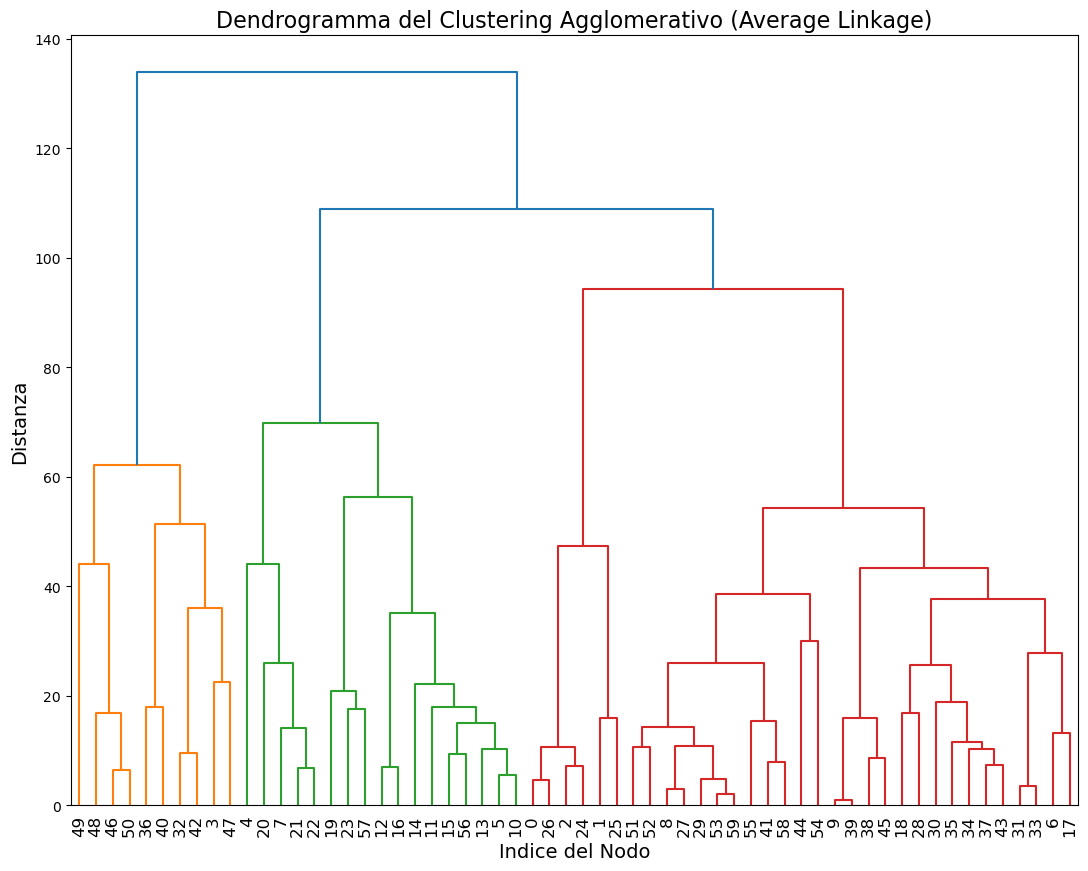

Cophenetic Correlation Coefficient: 0.834


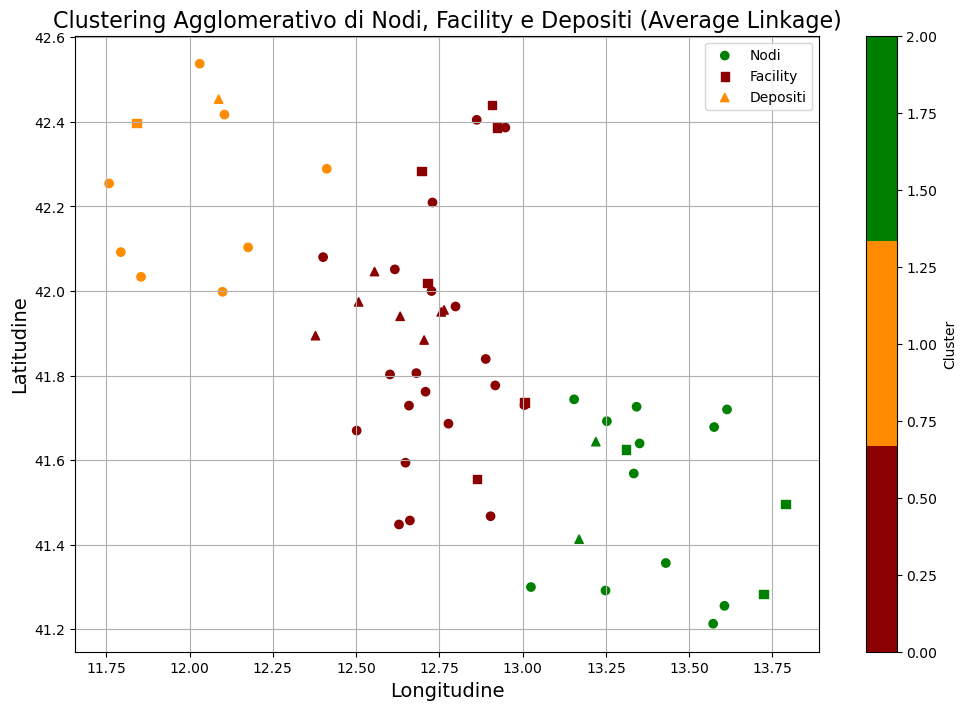

Episodio: 5, Reward: -2437095.833333333, Epsilon: 0.99,Learning Rate: 0.384238404, tempo: 53.18566666666667
Episodio: 10, Reward: -2974388.5000000005, Epsilon: 0.9801,Learning Rate: 0.36540689899345635, tempo: 55.174666666666674
Episodio: 15, Reward: -1992149.0, Epsilon: 0.9702989999999999,Learning Rate: 0.3474983251075913, tempo: 53.999333333333325
Episodio: 20, Reward: -1914358.8333333333, Epsilon: 0.96059601,Learning Rate: 0.3304674495342347, tempo: 56.57000000000001
Episodio: 25, Reward: -3811783.5000000005, Epsilon: 0.9509900498999999,Learning Rate: 0.31427125632288755, tempo: 64.76066666666667
Episodio: 30, Reward: -2631766.0, Epsilon: 0.9414801494009999,Learning Rate: 0.29886883773263845, tempo: 55.52916666666666
Episodio: 35, Reward: -2937664.833333334, Epsilon: 0.9320653479069899,Learning Rate: 0.28422129090891685, tempo: 57.0895
Episodio: 40, Reward: -2356544.0, Epsilon: 0.92274469442792,Learning Rate: 0.27029161962411324, tempo: 56.67433333333334
Episodio: 45, Reward: -20966

In [14]:
# Creazione dell'agente di Q-learning
ql_vrp = QLearningVRP(nodes_posizioni, demands, vehicle_capacities, facility_posizioni, facility_capacities,
                      depot_posizioni, num_veicoli, matrice_distanze, matrice_durate)

# Addestramento dell'agente #3980

rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode, tempi_totali_per_episode = ql_vrp.addestramento(
    num_episodi=3995)  #5000


#impiega per l'addestramento 3 min e 50

0
1
2
3
8
9


C:\Users\eleon\AppData\Local\Temp\ipykernel_5760\1110323292.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)


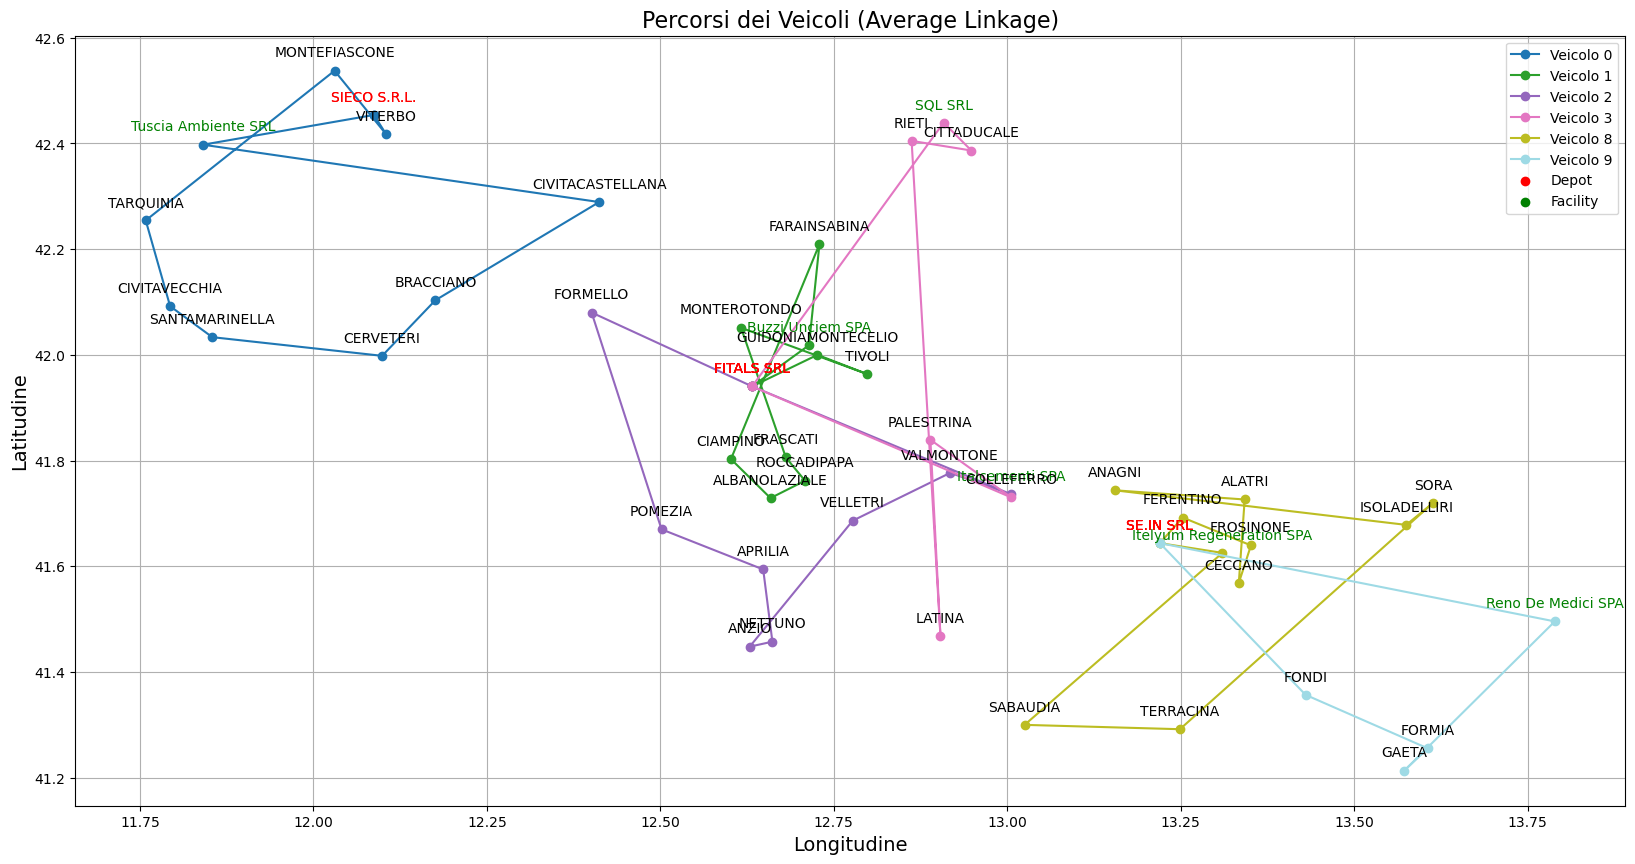

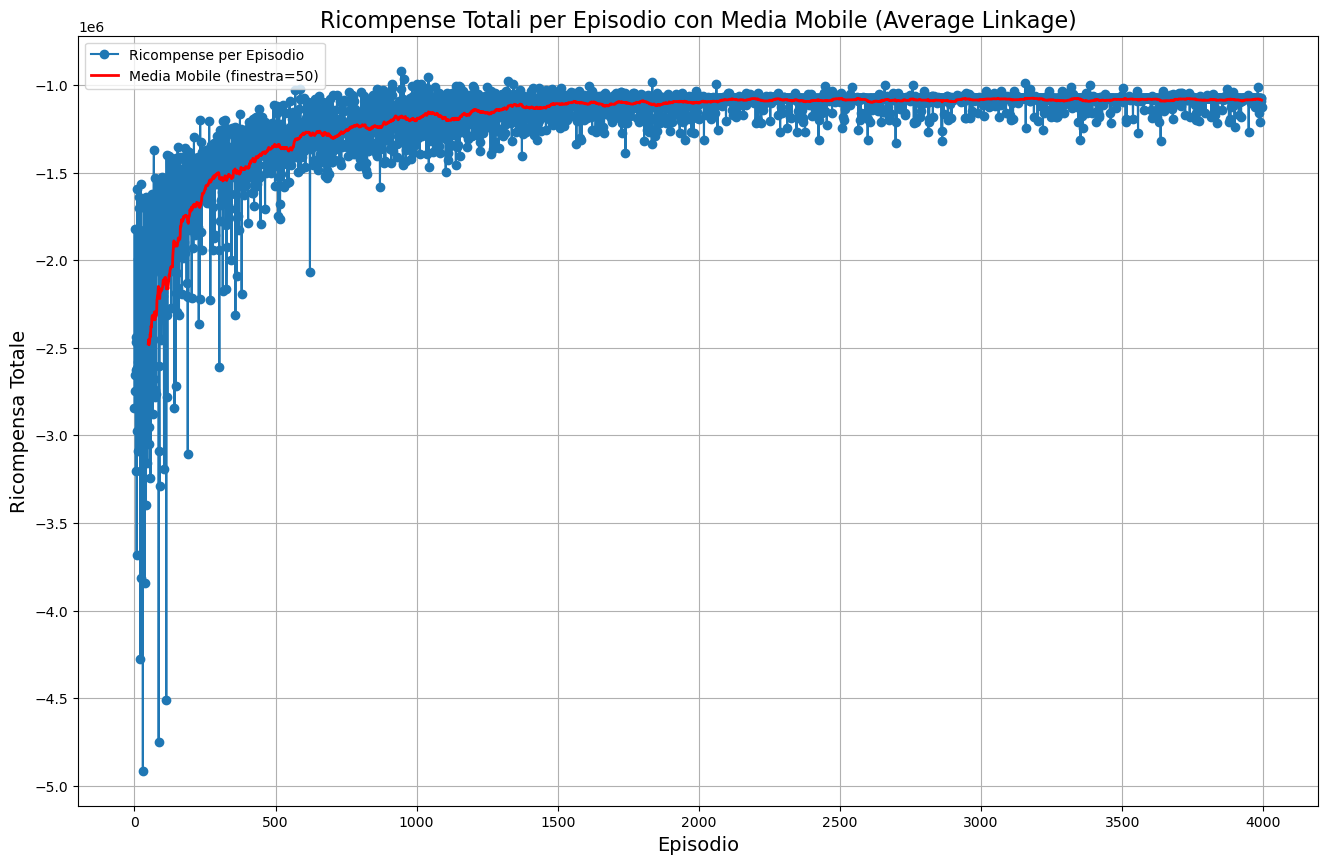

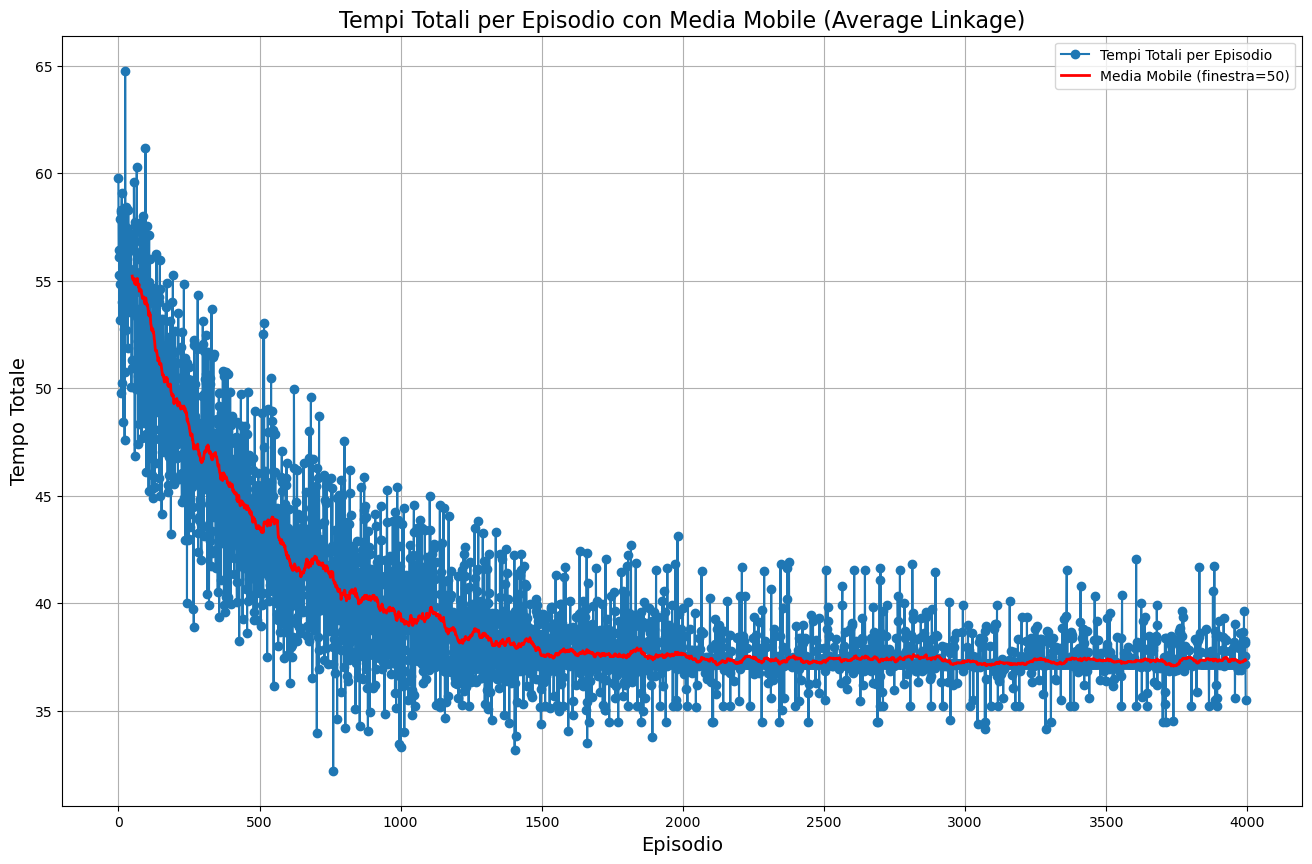

In [15]:
# # Visualizzazione dell'ultimo cammino trovato
ql_vrp.plot_cammino(facility_names, ultimo_cammino)
ql_vrp.plot_rewards_per_episode(rewards_per_episode, window_size=50)
# Plottare i tempi totali per episodio
ql_vrp.plot_tempi_totali_per_episode(tempi_totali_per_episode)
